In [2]:
import glob
import os
import pandas as pd
# Numpy for numpy.arrays
import numpy as np

# Include ITK for DICOM reading.
import itk

# Include pydicom_seg for DICOM SEG objects
import pydicom
import pydicom_seg

# for downloading data from TCIA
from tcia_utils import nbia

# This is the most common import command for itkWidgets.
#   The view() function opens an interactive viewer for 2D and 3D
#   data in a variety of formats.
from itkwidgets import view

# imports for monai
import torch
from monai.data import decollate_batch
from monai.bundle import ConfigParser, download
from monai.config import print_config

import SimpleITK as sitk
import nibabel as nib
from tqdm import tqdm

2024-04-22 18:13:47,564:WARNING:From c:\Users\Joel Fischer\.conda\envs\segmentationenv\Lib\site-packages\keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.



In [3]:
#import the pirads file and change the rownames:
pirads = pd.read_excel('Pirads.xlsx')
pirads.rename(columns={'Unnamed: 0': 'lesion_name'},inplace=True)
pirads.index = list(pirads['lesion_name'])
pirads.drop('lesion_name',axis=1,inplace=True)

In [4]:
translation = pd.read_excel('C:\\Users\\Joel Fischer\\Documents\\Masterarbeit\\Studie\\Projekt\\Auswertungsdaten\\Benchmark\\translation.xlsx')
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
translation.drop(8,inplace=True) #remove the bell_0027 case as its metadata is missing.


In [5]:
piquals =  pd.read_excel("C:/Users/Joel Fischer/Documents/Masterarbeit/Studie/Projekt/Auswertungsdaten/20230814_KSA-study_Image-Quality_Master.xlsx")
piquals.index = piquals['Case']

In [6]:
#Get all lesion filenames:
lesion_filenames = []
directory = 'E:\\ksa_study_data'
for path, dirs, filenames in os.walk(directory):
    for f in filenames:
        if f.endswith('.nii.gz'):
            #get only the files of the 67 Cases we have biopsied totally:
            name = f.split('_')[0].split('-')[0] + '_' + f.split('_')[0].split('-')[1]
            #we need to manual add the bell_0045 Case as it is missing in the translation:
            if name in list(translation['Case']) or name == 'bell_0045':
                #we only want lesions of t2w images, not full prostate segmentations or t2w images:
                if f.split('.')[0].split('_')[-1] != 'none':
                    if f.split('_')[1] == 't2w':
                        if f.split('_')[2] != 'pro':
                            #we don't want the files made for the visualizations:
                            if f.split('.')[-3].split('_')[-1] != 'test':
                                lesion_filenames.append(f)

In [7]:
def number_lesions_Case(pirads,Case):
    pirads_patient = pirads[pirads['Case'] == Case]
    number_lesions = 0
    liste = []
    for i in pirads_patient.index:
        number = int(pirads_patient.loc[i,'Content'].split('-')[1])
        liste.append(number)
    return(max(liste) + 1)

def get_filenames_of_Case(Case_segmentations):
    n_pcai100_auto = []
    n_rad1_rad = []
    n_rad1_ass = []
    n_rad2_rad = []
    n_rad2_ass = []
    n_rad3_rad = []
    n_rad3_ass = []

    for segmentation in Case_segmentations:
        if segmentation.split('.')[-3].split('_')[-1] == 'auto' and segmentation.split('.')[-3].split('_')[-2] == 'pcai100':
            n_pcai100_auto.append(segmentation)
        if segmentation.split('.')[-3].split('_')[-1] == 'rad' and segmentation.split('.')[-3].split('_')[-2] == 'rad1':
            n_rad1_rad.append(segmentation)
        if segmentation.split('.')[-3].split('_')[-1] == 'ass' and segmentation.split('.')[-3].split('_')[-2] == 'rad1':
            n_rad1_ass.append(segmentation)
        if segmentation.split('.')[-3].split('_')[-1] == 'rad' and segmentation.split('.')[-3].split('_')[-2] == 'rad2':
            n_rad2_rad.append(segmentation)
        if segmentation.split('.')[-3].split('_')[-1] == 'ass' and segmentation.split('.')[-3].split('_')[-2] == 'rad2':
            n_rad2_ass.append(segmentation)
        if segmentation.split('.')[-3].split('_')[-1] == 'rad' and segmentation.split('.')[-3].split('_')[-2] == 'rad3':
            n_rad3_rad.append(segmentation)
        if segmentation.split('.')[-3].split('_')[-1] == 'ass' and segmentation.split('.')[-3].split('_')[-2] == 'rad3':
            n_rad3_ass.append(segmentation)
    return(n_pcai100_auto,n_rad1_rad,n_rad1_ass,n_rad2_rad,n_rad2_ass,n_rad3_rad,n_rad3_ass)

def get_segmentation_array(filename):
    seg = nib.load(filename)
    sx,sy,sz = seg.header.get_zooms()
    return (seg.get_fdata(), sx, sy, sz)

In [8]:
def lesion_volume(lesion_segmentation,sx,sy,sz):
    n_pixels = 0
    for i in range(lesion_segmentation.shape[0]):
        for j in range(lesion_segmentation.shape[1]):
            for k in range(lesion_segmentation.shape[2]):
                if lesion_segmentation[i,j,k] == 1:
                    n_pixels = n_pixels + 1
    
    volume = n_pixels*sx*sy*sz
    return volume,n_pixels

In [9]:

lesion_volumes = pd.DataFrame(columns=['volume_mm3','n_pixels','site','reader','annotation_type','PI-QUAL','PI-RADS'])

Cases = list(translation['Case'])
Cases.append('bell_0045')

for Case in tqdm(Cases):
    #site:
    site = Case.split('_')[0]
    #Get the Case name with the '-':
    Case_name = Case.split('_')[0] + '-' + Case.split('_')[1]
    #Get only the filenames for the specific Case:
    Case_segmentation_names = [i for i in lesion_filenames if i.startswith(Case_name)]
    #this case has no PIQUAL score:
    if Case != 'bell_0045':
        PI_QUAL_score = piquals.loc[Case_name,'Image quality PI-QUAL']
    else:
        PI_QUAL_score = 'missing'

    for lesion in Case_segmentation_names:
        filename_of_lesion = f"E:/ksa_study_data/{site}/{Case_name}/{lesion}"
        reader = lesion.split('_')[-2]
        annotation_type = lesion.split('_')[-1].split('.')[-3]
        PIRADS_score = filename_of_lesion.split('-')[-4]
        volume, n_pixels = lesion_volume(get_segmentation_array(filename_of_lesion)[0],get_segmentation_array(filename_of_lesion)[1],get_segmentation_array(filename_of_lesion)[2],get_segmentation_array(filename_of_lesion)[3])
        lesion_volumes.loc[lesion] = [volume,n_pixels,site,reader,annotation_type,PI_QUAL_score,PIRADS_score] 
        
    

  0%|          | 0/67 [00:00<?, ?it/s]

100%|██████████| 67/67 [25:03<00:00, 22.44s/it]


In [10]:
with pd.ExcelWriter('volumes_of_lesions.xlsx') as writer:  
    lesion_volumes.to_excel(writer, sheet_name='Lesion_volumes')

# Get basic statistics:

In [11]:
count_auto = []

count_rad1 = []
count_rad2 = []
count_rad3 = []

count_ass1 = []
count_ass2 = []
count_ass3 = []



for lesion in lesion_volumes.index:
    reader = lesion.split('_')[-2]
    ann_type = lesion.split('_')[-1].split('.')[-3]
    if reader == 'pcai100':
        count_auto.append(lesion_volumes.loc[lesion,'volume_mm3'])
    if ann_type == 'rad':
        if reader == 'rad1':
            count_rad1.append(lesion_volumes.loc[lesion,'volume_mm3'])
        if reader == 'rad2':
            count_rad2.append(lesion_volumes.loc[lesion,'volume_mm3'])
        if reader == 'rad3':
            count_rad3.append(lesion_volumes.loc[lesion,'volume_mm3'])

    if ann_type == 'ass':
        if reader == 'rad1':
            count_ass1.append(lesion_volumes.loc[lesion,'volume_mm3']) 
        if reader == 'rad2':
            count_ass2.append(lesion_volumes.loc[lesion,'volume_mm3'])
        if reader == 'rad3':
            count_ass3.append(lesion_volumes.loc[lesion,'volume_mm3'])       

print()

In [12]:
from statistics import NormalDist
import statistics as stats

#confidence interval with assumed normal distribution:
def confidence_interval(data, confidence=0.95):
  dist = NormalDist.from_samples(data)
  z = NormalDist().inv_cdf((1 + confidence) / 2.)
  h = dist.stdev * z / ((len(data) - 1) ** .5)
  return dist.mean,dist.mean - h, dist.mean + h, h


#CI of mean with bootstrapping for any distribution:
def confidence_interval_mean(data,alpha=0.95):
    num_bootstraps = 10000

    # Initialize array to store medians from bootstrapped samples
    bootstrapped_medians = np.zeros(num_bootstraps)

    # Resampling and calculating medians
    for i in range(num_bootstraps):
        bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
        bootstrapped_medians[i] = np.mean(bootstrap_sample)

    # Calculating confidence interval
    confidence_interval_median = np.percentile(bootstrapped_medians, [(100-100*alpha), 100*alpha])
    median = stats.mean(data)

    return round(median,3), confidence_interval_median

#CI of median with bootstrapping for any distribution:
def confidence_interval_median(data,alpha=0.95):
    num_bootstraps = 10000

    # Initialize array to store medians from bootstrapped samples
    bootstrapped_medians = np.zeros(num_bootstraps)

    # Resampling and calculating medians
    for i in range(num_bootstraps):
        bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
        bootstrapped_medians[i] = np.median(bootstrap_sample)

    # Calculating confidence interval
    confidence_interval_median = np.percentile(bootstrapped_medians, [(100-100*alpha), 100*alpha])
    median = stats.median(data)

    return round(median,3), confidence_interval_median

In [13]:

print('n: ',len(count_auto),'n_per_case: ',len(count_auto)/67 ,'auto: mean' ,confidence_interval_mean(count_auto), 'median: ',confidence_interval_median(count_auto))

print('n: ',len(count_rad1) ,'n_per_case: ',len(count_rad1)/67 ,'rad1: mean' ,confidence_interval_mean(count_rad1), 'median: ',confidence_interval_median(count_rad1))
print('n: ',len(count_rad2) ,'n_per_case: ',len(count_rad2)/67 ,'rad2: mean' ,confidence_interval_mean(count_rad2), 'median: ',confidence_interval_median(count_rad2))
print('n: ',len(count_rad3) ,'n_per_case: ',len(count_rad3)/67 ,'rad3: mean' ,confidence_interval_mean(count_rad3), 'median: ',confidence_interval_median(count_rad3))

print('n: ',len(count_ass1) ,'n_per_case: ',len(count_ass1)/67 ,'ass1: mean' ,confidence_interval_mean(count_ass1),'median: ',confidence_interval_median(count_ass1))
print('n: ',len(count_ass2) ,'n_per_case: ',len(count_ass2)/67 ,'ass2: mean' ,confidence_interval_mean(count_ass2), 'median: ',confidence_interval_median(count_ass2))
print('n: ',len(count_ass3) ,'n_per_case: ',len(count_ass3)/67 ,'ass3: mean' ,confidence_interval_mean(count_ass3), 'median: ',confidence_interval_median(count_ass3))

n:  285 n_per_case:  4.253731343283582 auto: mean (1489.944, array([ 999.33329661, 2072.67517005])) median:  (207.504, array([160.62423474, 268.44726175]))
n:  44 n_per_case:  0.6567164179104478 rad1: mean (1343.559, array([ 932.41163892, 1818.82959925])) median:  (751.461, array([542.07595042, 864.55809298]))
n:  66 n_per_case:  0.9850746268656716 rad2: mean (292.364, array([234.56891029, 354.81095135])) median:  (165.5, array([141.74903665, 210.71542104]))
n:  87 n_per_case:  1.2985074626865671 rad3: mean (262.536, array([224.88986596, 303.09930751])) median:  (204.657, array([183.32381937, 232.67074249]))
n:  77 n_per_case:  1.1492537313432836 ass1: mean (970.029, array([ 636.76787974, 1355.02717185])) median:  (410.566, array([360.53466276, 508.02657347]))
n:  68 n_per_case:  1.0149253731343284 ass2: mean (604.663, array([303.08409097, 992.49932592])) median:  (239.421, array([196.15447884, 310.39338632]))
n:  78 n_per_case:  1.164179104477612 ass3: mean (727.284, array([ 410.61578

# Plotting the lesion volumes against PI-QUAL

In [14]:
import matplotlib.pyplot as plt
#make colormap for annotation types:
cmap = plt.cm.get_cmap('viridis')
ai_color = cmap(0.1)
manual_color = cmap(0.3)
assisted_color = cmap(0.6)

#colormap for piquals:
cmap = plt.cm.get_cmap('cividis')
piqual3_color = cmap(0.1)
piqual_3_and_4_color = cmap(0.3)
piqual4_color = cmap(0.6)
piqual5_color = cmap(0.9)

#colormap for pirads:
cmap = plt.cm.get_cmap('cividis')
pirads1_color = cmap(0.1)
pirads3_color = cmap(0.3)
pirads4_color = cmap(0.6)
pirads5_color = cmap(0.9)

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


In [15]:
#remove Bell_0045 as it has missing PI-QUAL scores:
lesion_volumes_no_missing = lesion_volumes.copy()
for i in lesion_volumes.index:
    lesion_volumes.loc[i,'PI-RADS'] = int(lesion_volumes.loc[i,'PI-RADS'])
    if lesion_volumes.loc[i,'PI-QUAL'] == 'missing':
        lesion_volumes_no_missing.drop(i,inplace=True)

2024-04-22 18:39:03,311:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-04-22 18:39:03,323:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.




0 AndersonResult(statistic=0.29787348864741414, critical_values=array([1.317, 1.499, 1.799, 2.098, 2.496]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=147.835613635274, scale=140.80081744402227)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
1 AndersonResult(statistic=0.2716265266567035, critical_values=array([0.72 , 0.82 , 0.984, 1.148, 1.365]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=489.32654193898315, scale=482.3225777837654)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
2 AndersonResult(statistic=19.96622190452294, critical_values=array([0.56 , 0.638, 0.765, 0.893, 1.062]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=258.6070481114278, scale=520.1019476038032)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
3 Ander

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'PI-QUAL_3_PI-RADS5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.


,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,cohen
0,piqual_pirads,PI-QUAL_3_PI-RADS1,PI-QUAL_3_PI-RADS3,False,False,8.0,two-sided,1.482517e-01,1.000000e+00,bonf,-0.806496
1,piqual_pirads,PI-QUAL_3_PI-RADS1,PI-QUAL_3_PI-RADS4,False,False,50.5,two-sided,1.675175e-01,1.000000e+00,bonf,-0.470390
2,piqual_pirads,PI-QUAL_3_PI-RADS1,PI-QUAL_3_PI-RADS5,False,False,26.0,two-sided,4.022853e-02,1.000000e+00,bonf,-0.672682
3,piqual_pirads,PI-QUAL_3_PI-RADS1,PI-QUAL_4_PI-RADS1,False,False,7.0,two-sided,5.555556e-01,1.000000e+00,bonf,-0.908045
4,piqual_pirads,PI-QUAL_3_PI-RADS1,PI-QUAL_4_PI-RADS3,False,False,3.0,two-sided,4.000000e-01,1.000000e+00,bonf,-0.726262
5,piqual_pirads,PI-QUAL_3_PI-RADS1,PI-QUAL_4_PI-RADS4,False,False,20.0,two-sided,1.952153e-01,1.000000e+00,bonf,-0.738052
6,piqual_pirads,PI-QUAL_3_PI-RADS1,PI-QUAL_4_PI-RADS5,False,False,13.0,two-sided,9.498298e-03,6.268877e-01,bonf,-0.866464
7,piqual_pirads,PI-QUAL_3_PI-RADS1,PI-QUAL_5_PI-RADS1,False,False,247.0,two-sided,7.768128e-01,1.000000e+00,bonf,-0.215175
8,piqual_pirads,PI-QUAL_3_PI-RADS1,PI-QUAL_5_PI-RADS3,False,False,31.0,two-sided,4.515415e-01,1.000000e+00,bonf,-0.476875
9,piqual_pirads,PI-QUAL_3_PI-RADS1,PI-QUAL_5_PI-RADS4,False,False,265.0,two-sided,1.497649e-01,1.000000e+00,bonf,-0.598652


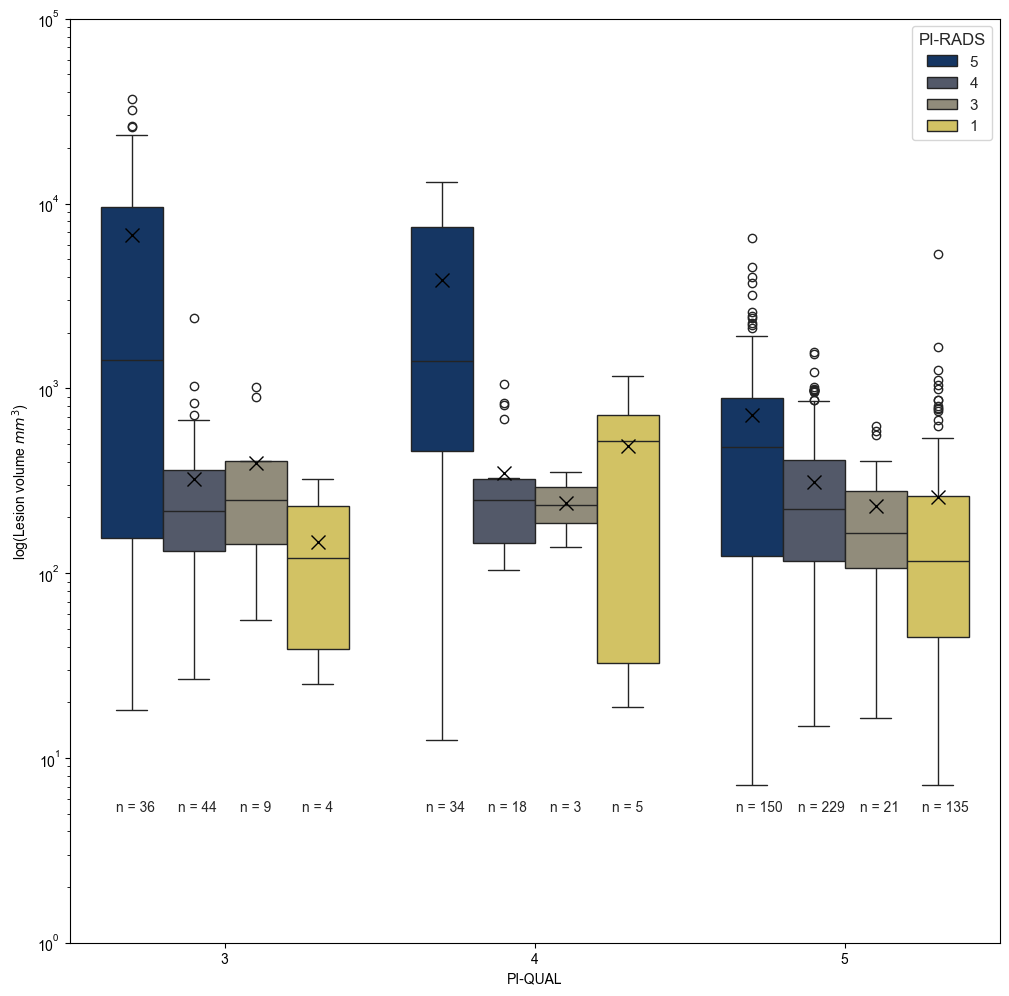

In [16]:
import seaborn as sns

import scikit_posthocs as sp
import scipy
import pingouin as pg
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,12))

#Create boxplots:
sns.set_theme(style="ticks")

sns.boxplot(ax=ax, x="PI-QUAL", y="volume_mm3", palette=[pirads1_color,pirads3_color,pirads4_color,pirads5_color],
            hue="PI-RADS",whis=1.5,showmeans=True,
                        meanprops={"marker":"x",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},  data=lesion_volumes_no_missing, dodge=True)

plt.yscale('log')
plt.ylim([1,100000])
plt.ylabel(r'log(Lesion volume $mm^3$)')

pirads_1_piqual3 = lesion_volumes_no_missing.loc[(lesion_volumes_no_missing['PI-RADS'] == '1')& (lesion_volumes_no_missing['PI-QUAL'] == 3) ]
pirads_1_piqual4 = lesion_volumes_no_missing.loc[(lesion_volumes_no_missing['PI-RADS'] == '1')& (lesion_volumes_no_missing['PI-QUAL'] == 4) ]
pirads_1_piqual5 = lesion_volumes_no_missing.loc[(lesion_volumes_no_missing['PI-RADS'] == '1')& (lesion_volumes_no_missing['PI-QUAL'] == 5) ]

pirads_3_piqual3 = lesion_volumes_no_missing.loc[(lesion_volumes_no_missing['PI-RADS'] == '3')& (lesion_volumes_no_missing['PI-QUAL'] == 3) ]
pirads_3_piqual4 = lesion_volumes_no_missing.loc[(lesion_volumes_no_missing['PI-RADS'] == '3')& (lesion_volumes_no_missing['PI-QUAL'] == 4) ]
pirads_3_piqual5 = lesion_volumes_no_missing.loc[(lesion_volumes_no_missing['PI-RADS'] == '3')& (lesion_volumes_no_missing['PI-QUAL'] == 5) ]

pirads_4_piqual3 = lesion_volumes_no_missing.loc[(lesion_volumes_no_missing['PI-RADS'] == '4')& (lesion_volumes_no_missing['PI-QUAL'] == 3) ]
pirads_4_piqual4 = lesion_volumes_no_missing.loc[(lesion_volumes_no_missing['PI-RADS'] == '4')& (lesion_volumes_no_missing['PI-QUAL'] == 4) ]
pirads_4_piqual5 = lesion_volumes_no_missing.loc[(lesion_volumes_no_missing['PI-RADS'] == '4')& (lesion_volumes_no_missing['PI-QUAL'] == 5) ]

pirads_5_piqual3 = lesion_volumes_no_missing.loc[(lesion_volumes_no_missing['PI-RADS'] == '5')& (lesion_volumes_no_missing['PI-QUAL'] == 3) ]
pirads_5_piqual4 = lesion_volumes_no_missing.loc[(lesion_volumes_no_missing['PI-RADS'] == '5')& (lesion_volumes_no_missing['PI-QUAL'] == 4) ]
pirads_5_piqual5 = lesion_volumes_no_missing.loc[(lesion_volumes_no_missing['PI-RADS'] == '5')& (lesion_volumes_no_missing['PI-QUAL'] == 5) ]

z = 0.2

plt.text(x = -0.35+0*z, y = 5.1, s = f"n = {pirads_5_piqual3.shape[0]}", size = 10)
plt.text(x = -0.35+1*z, y = 5.1, s = f"n = {pirads_4_piqual3.shape[0]}", size = 10)
plt.text(x = -0.35+2*z, y = 5.1, s = f"n = {pirads_3_piqual3.shape[0]}", size = 10)
plt.text(x = -0.35+3*z, y = 5.1, s = f"n = {pirads_1_piqual3.shape[0]}", size = 10)


plt.text(x = -0.35+0.2+4*z, y = 5.1, s = f"n = {pirads_5_piqual4.shape[0]}", size = 10)
plt.text(x = -0.35+0.2+5*z, y = 5.1, s = f"n = {pirads_4_piqual4.shape[0]}", size = 10)
plt.text(x = -0.35+0.2+6*z, y = 5.1, s = f"n = {pirads_3_piqual4.shape[0]}", size = 10)
plt.text(x = -0.35+0.2+7*z, y = 5.1, s = f"n = {pirads_1_piqual4.shape[0]}", size = 10)

plt.text(x = -0.35+0.4+8*z, y = 5.1, s = f"n = {pirads_5_piqual5.shape[0]}", size = 10)
plt.text(x = -0.35+0.4+9*z, y = 5.1, s = f"n = {pirads_4_piqual5.shape[0]}", size = 10)
plt.text(x = -0.35+0.4+10*z, y = 5.1, s = f"n = {pirads_3_piqual5.shape[0]}", size = 10)
plt.text(x = -0.35+0.4+11*z, y = 5.1, s = f"n = {pirads_1_piqual5.shape[0]}", size = 10)


path = 'figures_volume_calculation/PI_QUAL_P_RADS.svg'
plt.savefig(path, format='svg',bbox_inches='tight')

#--------------------------------------------------------------------------------------
distributions = [pirads_1_piqual3['volume_mm3'],pirads_1_piqual4['volume_mm3'],pirads_1_piqual5['volume_mm3'],
                 pirads_3_piqual3['volume_mm3'],pirads_3_piqual4['volume_mm3'],pirads_3_piqual5['volume_mm3'],
                 pirads_4_piqual3['volume_mm3'],pirads_4_piqual4['volume_mm3'],pirads_4_piqual5['volume_mm3'],
                 pirads_5_piqual3['volume_mm3'],pirads_5_piqual4['volume_mm3'],pirads_5_piqual5['volume_mm3'],
]

#basic statistics:
means_medians = pd.DataFrame(columns=[3,4,5])
means_medians.loc['Pirads1'] = [confidence_interval_mean(pirads_1_piqual3['volume_mm3']),confidence_interval_mean(pirads_1_piqual4['volume_mm3']),confidence_interval_mean(pirads_1_piqual5['volume_mm3'])] 
means_medians.loc['Pirads3'] = [confidence_interval_mean(pirads_3_piqual3['volume_mm3']),confidence_interval_mean(pirads_3_piqual4['volume_mm3']),confidence_interval_mean(pirads_3_piqual5['volume_mm3'])] 
means_medians.loc['Pirads4'] = [confidence_interval_mean(pirads_4_piqual3['volume_mm3']),confidence_interval_mean(pirads_4_piqual4['volume_mm3']),confidence_interval_mean(pirads_4_piqual5['volume_mm3'])] 
means_medians.loc['Pirads5'] = [confidence_interval_mean(pirads_5_piqual3['volume_mm3']),confidence_interval_mean(pirads_5_piqual4['volume_mm3']),confidence_interval_mean(pirads_5_piqual5['volume_mm3'])] 

print('\n')
#check for distribution type:
for i, distribution in enumerate(distributions):
    print(i,scipy.stats.anderson(distribution,dist='norm'))

#--> no normal distributions

print('\n')

#Kruskal Wallis for any number of distributions:
print(scipy.stats.kruskal(pirads_1_piqual3['volume_mm3'],pirads_1_piqual4['volume_mm3'],pirads_1_piqual5['volume_mm3'],
                 pirads_3_piqual3['volume_mm3'],pirads_3_piqual4['volume_mm3'],pirads_3_piqual5['volume_mm3'],
                 pirads_4_piqual3['volume_mm3'],pirads_4_piqual4['volume_mm3'],pirads_4_piqual5['volume_mm3'],
                 pirads_5_piqual3['volume_mm3'],pirads_5_piqual4['volume_mm3'],pirads_5_piqual5['volume_mm3'], nan_policy='propagate', axis=0, keepdims=False))

print('\n')
#if the Kruskal-Wallis test indicates a significance, the Dunn's multiple comparison/posthoc test is used:
#IT tells wheter the medians of the two distributions are significantly different!
#p_values= sp.posthoc_dunn([piqual_3['volume_mm3'],piqual_4['volume_mm3'],piqual_5['volume_mm3']],p_adjust = 'bonferroni')
#p_values

lesion_volumes_pirads_piqual = lesion_volumes_no_missing.copy()
lesion_volumes_pirads_piqual['piqual_pirads'] = 0
for lesion in lesion_volumes_pirads_piqual.index:
    lesion_volumes_pirads_piqual.loc[lesion,'piqual_pirads'] = f"PI-QUAL_{lesion_volumes_pirads_piqual.loc[lesion,'PI-QUAL']}_PI-RADS{lesion_volumes_pirads_piqual.loc[lesion,'PI-RADS']}"

pg.pairwise_tests(data=lesion_volumes_pirads_piqual,dv='volume_mm3',alpha=0.05,parametric=False,between='piqual_pirads',padjust='bonf',effsize='cohen',alternative='two-sided')
#bonferroni_corrected_alpha = 0.05/3
#print(p_values < bonferroni_corrected_alpha)

2024-04-22 18:39:10,518:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

2024-04-22 18:39:10,528:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


means: sd_pirads1: (263.541, array([202.3230945 , 340.20379773]))  sd_pirads3:  (275.273, array([213.22789467, 344.17554748]))  sd_pirads4:  (315.217, array([288.00340237, 343.52415094]))  sd_pirads5:  (2361.445, array([1743.49195548, 3060.61424783]))
medians: sd_pirads1: (119.42, array([ 98.94077157, 156.55311914]))  sd_pirads3:  (232.671, array([138.45711889, 247.74169564]))  sd_pirads4:  (222.802, array([203.43017284, 239.27192574]))  sd_pirads5:  (569.957, array([498.50463147, 653.84673127]))


AndersonResult(statistic=20.09660532370532, critical_values=array([0.561, 0.639, 0.767, 0.894, 1.064]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=263.54115735610253, scale=512.4298118197412)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
AndersonResult(statistic=1.9885459473259601, critical_values=array([0.524, 0.597, 0.717, 0.836, 0.994]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_r

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,cohen
0,PI-RADS,1,3,False,False,1730.5,two-sided,1.512257e-02,9.073540e-02,bonf,-0.024752
1,PI-RADS,1,4,False,False,14382.0,two-sided,1.014021e-07,6.084125e-07,bonf,-0.136057
2,PI-RADS,1,5,False,False,8104.5,two-sided,8.300853e-18,4.980512e-17,bonf,-0.425227
3,PI-RADS,3,4,False,False,4522.0,two-sided,5.843228e-01,1.000000e+00,bonf,-0.138766
4,PI-RADS,3,5,False,False,2287.0,two-sided,1.125362e-04,6.752175e-04,bonf,-0.356268
5,PI-RADS,4,5,False,False,21506.0,two-sided,9.881021e-14,5.928612e-13,bonf,-0.488945


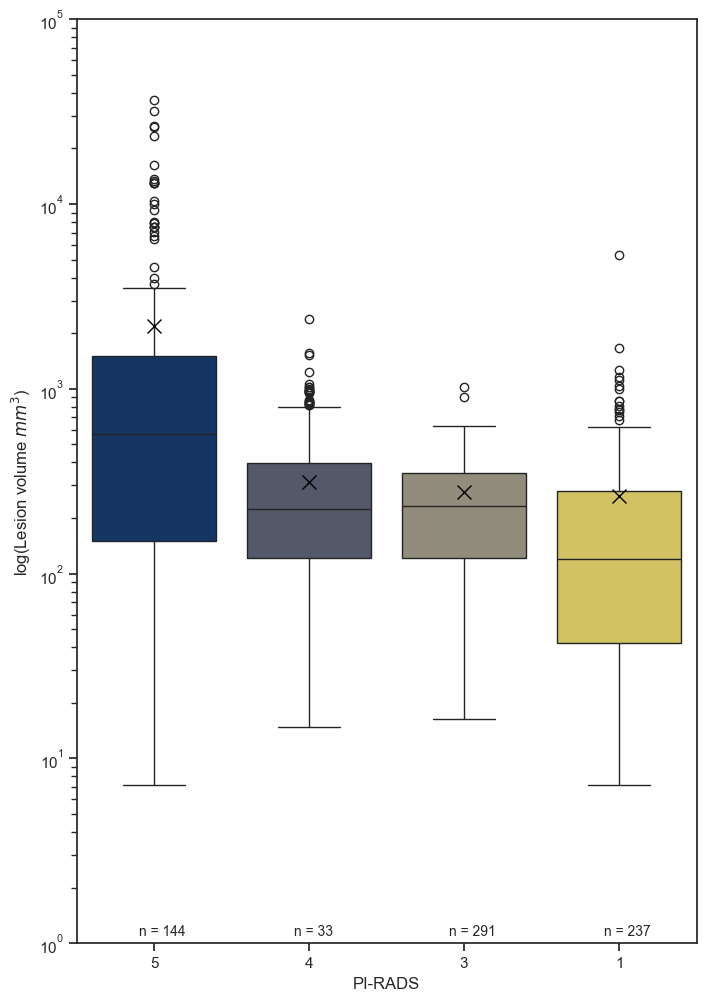

In [17]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(8,12))

#Create boxplots:
sns.set_theme(style="ticks")

sns.boxplot(ax=ax, x="PI-RADS", y="volume_mm3",palette=[pirads1_color,pirads3_color,pirads4_color,pirads5_color],
            whis=1.5,showmeans=True,
                        meanprops={"marker":"x",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},  data=lesion_volumes_no_missing)

plt.yscale('log')
plt.ylim([1,100000])
plt.ylabel(r'log(Lesion volume $mm^3$)')

pirads_1 = lesion_volumes.loc[(lesion_volumes['PI-RADS'] == 1)]
pirads_3 = lesion_volumes.loc[(lesion_volumes['PI-RADS'] == 3)]
pirads_4 = lesion_volumes.loc[(lesion_volumes['PI-RADS'] == 4)]
pirads_5 = lesion_volumes.loc[(lesion_volumes['PI-RADS'] == 5)]


plt.text(x = -0.1, y = 1.1, s = f"n = {pirads_1.shape[0]}", size = 10)
plt.text(x = -0.1+1, y = 1.1, s = f"n = {pirads_3.shape[0]}", size = 10)
plt.text(x = -0.1+2, y = 1.1, s = f"n = {pirads_4.shape[0]}", size = 10)
plt.text(x = -0.1+3, y = 1.1, s = f"n = {pirads_5.shape[0]}", size = 10)


path = 'figures_volume_calculation/PI_RADS.svg'
plt.savefig(path, format='svg',bbox_inches='tight')

#--------------------------------------------------------------------------------------
#basic statistics:

print('means: sd_pirads1:', confidence_interval_mean(pirads_1['volume_mm3']), ' sd_pirads3: ', confidence_interval_mean(pirads_3['volume_mm3']), ' sd_pirads4: ', confidence_interval_mean(pirads_4['volume_mm3']), ' sd_pirads5: ', confidence_interval_mean(pirads_5['volume_mm3']))
print('medians: sd_pirads1:', confidence_interval_median(pirads_1['volume_mm3']), ' sd_pirads3: ', confidence_interval_median(pirads_3['volume_mm3']), ' sd_pirads4: ', confidence_interval_median(pirads_4['volume_mm3']), ' sd_pirads5: ', confidence_interval_median(pirads_5['volume_mm3']))
print('\n')
#check for distribution type:
print(scipy.stats.anderson(pirads_1['volume_mm3'],dist='norm'))
print(scipy.stats.anderson(pirads_3['volume_mm3'],dist='norm'))
print(scipy.stats.anderson(pirads_4['volume_mm3'],dist='norm'))
print(scipy.stats.anderson(pirads_5['volume_mm3'],dist='norm'))
#--> no normal distributions

print('\n')

#Kruskal Wallis for any number of distributions:
print(scipy.stats.kruskal(pirads_1['volume_mm3'],pirads_3['volume_mm3'], pirads_4['volume_mm3'], pirads_5['volume_mm3'], nan_policy='propagate', axis=0, keepdims=False))

print('\n')
#if the Kruskal-Wallis test indicates a significance, the Dunn's multiple comparison/posthoc test is used:
#IT tells wheter the medians of the two distributions are significantly different!
#p_values= sp.posthoc_dunn([piqual_3['volume_mm3'],piqual_4['volume_mm3'],piqual_5['volume_mm3']],p_adjust = 'bonferroni')
#p_values

pg.pairwise_tests(data=lesion_volumes,dv='volume_mm3',alpha=0.05,parametric=False,between='PI-RADS',padjust='bonf',effsize='cohen',alternative='two-sided')
#bonferroni_corrected_alpha = 0.05/3
#print(p_values < bonferroni_corrected_alpha)

In [18]:
#change the annotation type names:
for lesion in lesion_volumes_no_missing.index:
    if lesion_volumes_no_missing.loc[lesion,'annotation_type'] == 'auto':
        lesion_volumes_no_missing.loc[lesion,'annotation_type'] = 'AI-Tool'
    if lesion_volumes_no_missing.loc[lesion,'annotation_type'] == 'rad':
        lesion_volumes_no_missing.loc[lesion,'annotation_type'] = 'Manual'
    if lesion_volumes_no_missing.loc[lesion,'annotation_type'] == 'ass':
        lesion_volumes_no_missing.loc[lesion,'annotation_type'] = 'Assisted'

for lesion in lesion_volumes.index:
    if lesion_volumes.loc[lesion,'annotation_type'] == 'auto':
        lesion_volumes.loc[lesion,'annotation_type'] = 'AI-Tool'
    if lesion_volumes.loc[lesion,'annotation_type'] == 'rad':
        lesion_volumes.loc[lesion,'annotation_type'] = 'Manual'
    if lesion_volumes.loc[lesion,'annotation_type'] == 'ass':
        lesion_volumes.loc[lesion,'annotation_type'] = 'Assisted'


2024-04-22 18:39:16,427:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-04-22 18:39:16,436:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Attempt to set non-positive ylim on a log-scaled axis will be ignored.


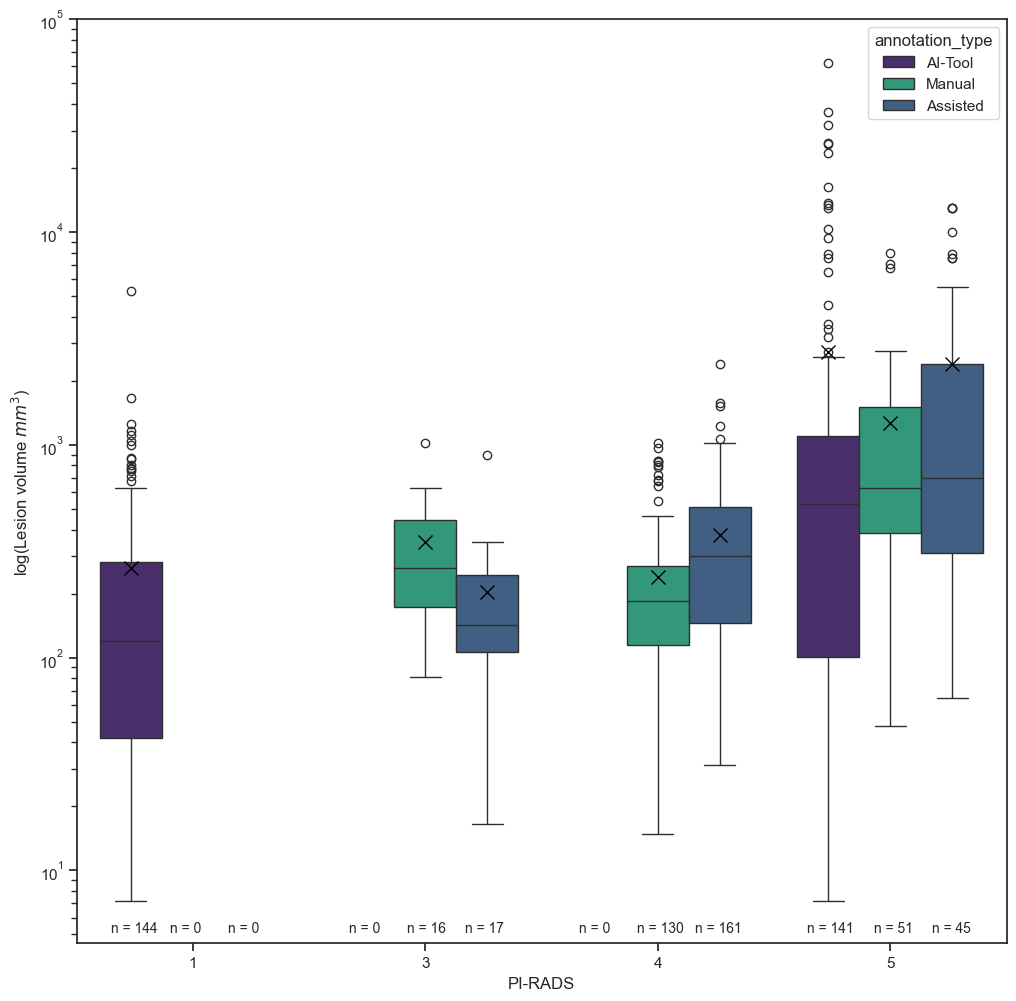

In [19]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,12))

#Create boxplots:
sns.set_theme(style="ticks")

sns.boxplot(ax=ax, x="PI-RADS", y="volume_mm3", palette=[ai_color,assisted_color,manual_color],
            hue="annotation_type",whis=1.5,showmeans=True,
                        meanprops={"marker":"x",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},  data=lesion_volumes, dodge=True)

plt.yscale('log')
plt.ylim([-10000,100000])
plt.ylabel(r'log(Lesion volume $mm^3$)')

pirads_1_AI = lesion_volumes.loc[(lesion_volumes['PI-RADS'] == 1)& (lesion_volumes['annotation_type'] == 'AI-Tool') ]
pirads_1_manual = lesion_volumes.loc[(lesion_volumes['PI-RADS'] == 1)& (lesion_volumes['annotation_type'] == 'Manual') ]
pirads_1_ass = lesion_volumes.loc[(lesion_volumes['PI-RADS'] == 1)& (lesion_volumes['annotation_type'] == 'Assisted') ]

pirads_3_AI = lesion_volumes.loc[(lesion_volumes['PI-RADS'] == 3)& (lesion_volumes['annotation_type'] == 'AI-Tool') ]
pirads_3_manual = lesion_volumes.loc[(lesion_volumes['PI-RADS'] == 3)& (lesion_volumes['annotation_type'] == 'Manual') ]
pirads_3_ass = lesion_volumes.loc[(lesion_volumes['PI-RADS'] == 3)& (lesion_volumes['annotation_type'] == 'Assisted') ]

pirads_4_AI = lesion_volumes.loc[(lesion_volumes['PI-RADS'] == 4)& (lesion_volumes['annotation_type'] == 'AI-Tool') ]
pirads_4_manual = lesion_volumes.loc[(lesion_volumes['PI-RADS'] == 4)& (lesion_volumes['annotation_type'] == 'Manual') ]
pirads_4_ass = lesion_volumes.loc[(lesion_volumes['PI-RADS'] == 4)& (lesion_volumes['annotation_type'] == 'Assisted') ]

pirads_5_AI = lesion_volumes.loc[(lesion_volumes['PI-RADS'] == 5)& (lesion_volumes['annotation_type'] == 'AI-Tool') ]
pirads_5_manual = lesion_volumes.loc[(lesion_volumes['PI-RADS'] == 5)& (lesion_volumes['annotation_type'] == 'Manual') ]
pirads_5_ass = lesion_volumes.loc[(lesion_volumes['PI-RADS'] == 5)& (lesion_volumes['annotation_type'] == 'Assisted') ]


z = 0.25

plt.text(x = -0.35+0*z, y = 5.1, s = f"n = {pirads_1_AI.shape[0]}", size = 10)
plt.text(x = -0.35+1*z, y = 5.1, s = f"n = {pirads_1_manual.shape[0]}", size = 10)
plt.text(x = -0.35+2*z, y = 5.1, s = f"n = {pirads_1_ass.shape[0]}", size = 10)

plt.text(x = -0.35+0.27+3*z, y = 5.1, s = f"n = {pirads_3_AI.shape[0]}", size = 10)
plt.text(x = -0.35+0.27+4*z, y = 5.1, s = f"n = {pirads_3_manual.shape[0]}", size = 10)
plt.text(x = -0.35+0.27+5*z, y = 5.1, s = f"n = {pirads_3_ass.shape[0]}", size = 10)

plt.text(x = -0.35+0.51+6*z, y = 5.1, s = f"n = {pirads_4_AI.shape[0]}", size = 10)
plt.text(x = -0.35+0.51+7*z, y = 5.1, s = f"n = {pirads_4_manual.shape[0]}", size = 10)
plt.text(x = -0.35+0.51+8*z, y = 5.1, s = f"n = {pirads_4_ass.shape[0]}", size = 10)

plt.text(x = -0.35+0.74+9*z, y = 5.1, s = f"n = {pirads_5_AI.shape[0]}", size = 10)
plt.text(x = -0.35+0.78+10*z, y = 5.1, s = f"n = {pirads_5_manual.shape[0]}", size = 10)
plt.text(x = -0.35+0.78+11*z, y = 5.1, s = f"n = {pirads_5_ass.shape[0]}", size = 10)


path = 'figures_volume_calculation/PI_RADS_annotation_type.svg'
plt.savefig(path, format='svg',bbox_inches='tight')

# Kruskal test

In [20]:
import math
#effect size is equivalent to cohens d:
def effect_size(a,b):
    cohens_d = (stats.mean(a) - stats.mean(b)) / (math.sqrt((stats.stdev(a) ** 2 + stats.stdev(b) ** 2) / 2))

    return(cohens_d)

2024-04-22 18:39:17,324:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

2024-04-22 18:39:17,338:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


means: sd_piqual3: (2802.125, array([1685.74158644, 4061.49832562]))  sd_piqual4:  (2332.526, array([1569.10767356, 3125.0280777 ]))  sd_piqual5:  (407.465, array([366.06005932, 451.52027859]))
medians: sd_piqual3: (270.544, array([221.09983845, 394.27187337]))  sd_piqual4:  (602.722, array([331.86479875, 892.61386582]))  sd_piqual5:  (218.607, array([198.62213027, 243.03359634]))


AndersonResult(statistic=22.12603598593313, critical_values=array([0.554, 0.631, 0.757, 0.883, 1.05 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=2802.12513635592, scale=7032.410644374941)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
AndersonResult(statistic=9.364460101401704, critical_values=array([0.544, 0.619, 0.743, 0.866, 1.03 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=2332.5260780028552, scale=3757.843303741489)
 success: True
 message: '`anderson` successfu

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,cohen
0,PI-QUAL,3,4,False,False,2313.0,two-sided,0.074969,0.224906,bonf,0.078651
1,PI-QUAL,3,5,False,False,29407.0,two-sided,0.005040,0.015120,bonf,0.869482
2,PI-QUAL,4,5,False,False,22163.5,two-sided,0.000001,0.000004,bonf,1.459507


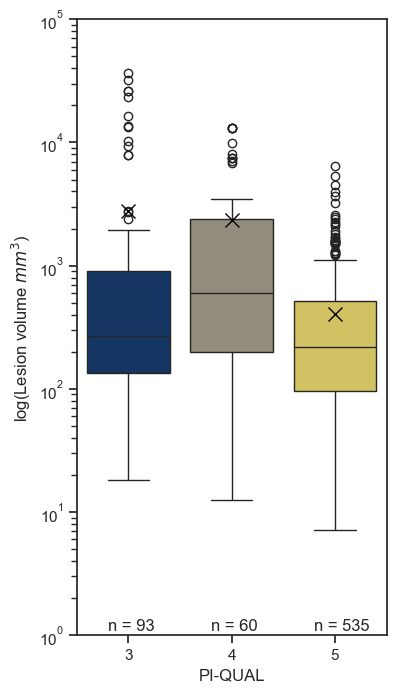

In [21]:
import pingouin as pg
path = 'figures_volume_calculation/PI_QUAL_3to5.svg'
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(4,8))

#Create boxplots:
sns.set_theme(style="ticks")

sns.boxplot(ax=ax, x="PI-QUAL", y="volume_mm3", whis=1.5,showmeans=True, palette=[piqual3_color,piqual4_color,piqual5_color],
                        meanprops={"marker":"x",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},  data=lesion_volumes_no_missing)


number_piqual_3 = lesion_volumes_no_missing.loc[(lesion_volumes_no_missing['PI-QUAL'] == 3)].shape[0]
number_piqual_4 = lesion_volumes_no_missing.loc[(lesion_volumes_no_missing['PI-QUAL'] == 4)].shape[0]
number_piqual_5 = lesion_volumes_no_missing.loc[(lesion_volumes_no_missing['PI-QUAL'] == 5)].shape[0]

label = ['n = ' + str(number_piqual_3) ,'n = ' + str(number_piqual_4),'n = ' + str(number_piqual_5)]

# Text at each boxplot:
plt.text(x = -0.2, y = 1.1, s = label[0], size = 12)
plt.text(x = -0.2+1, y = 1.1, s = label[1], size = 12)
plt.text(x = -0.2+2, y = 1.1, s = label[2], size = 12)

plt.yscale('log')
plt.ylim([1,100000])
plt.ylabel(r'log(Lesion volume $mm^3$)')


plt.savefig(path, format='svg',bbox_inches='tight')


#--------------------------------------------------------------------------------------
#basic statistics:

piqual_3 = lesion_volumes_no_missing.loc[(lesion_volumes_no_missing['PI-QUAL'] == 3)]
piqual_4 = lesion_volumes_no_missing.loc[(lesion_volumes_no_missing['PI-QUAL'] == 4)]
piqual_5 = lesion_volumes_no_missing.loc[(lesion_volumes_no_missing['PI-QUAL'] == 5)]

print('means: sd_piqual3:', confidence_interval_mean(piqual_3['volume_mm3']), ' sd_piqual4: ', confidence_interval_mean(piqual_4['volume_mm3']), ' sd_piqual5: ', confidence_interval_mean(piqual_5['volume_mm3']))
print('medians: sd_piqual3:', confidence_interval_median(piqual_3['volume_mm3']), ' sd_piqual4: ', confidence_interval_median(piqual_4['volume_mm3']), ' sd_piqual5: ', confidence_interval_median(piqual_5['volume_mm3']))
print('\n')
#check for distribution type:
print(scipy.stats.anderson(piqual_3['volume_mm3'],dist='norm'))
print(scipy.stats.anderson(piqual_4['volume_mm3'],dist='norm'))
print(scipy.stats.anderson(piqual_5['volume_mm3'],dist='norm'))
#--> no normal distributions

print('\n')

#Kruskal Wallis for any number of distributions:
print(scipy.stats.kruskal(piqual_3['volume_mm3'],piqual_4['volume_mm3'], piqual_5['volume_mm3'], nan_policy='propagate', axis=0, keepdims=False))

print('\n')
#if the Kruskal-Wallis test indicates a significance, the Dunn's multiple comparison/posthoc test is used:
#IT tells wheter the medians of the two distributions are significantly different!
#p_values= sp.posthoc_dunn([piqual_3['volume_mm3'],piqual_4['volume_mm3'],piqual_5['volume_mm3']],p_adjust = 'bonferroni')
#p_values

pg.pairwise_tests(data=lesion_volumes_no_missing,dv='volume_mm3',alpha=0.05,parametric=False,between='PI-QUAL',padjust='bonf',effsize='cohen',alternative='two-sided')
#bonferroni_corrected_alpha = 0.05/3
#print(p_values < bonferroni_corrected_alpha)

2024-04-22 18:39:22,031:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

2024-04-22 18:39:22,040:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


means: sd_piqual not 5: (2617.969, array([1858.00144081, 3442.90025665]))  sd_piqual5:  (407.465, array([366.72201478, 452.21589922]))
medians: sd_piqual not 5: (360.535, array([265.23191837, 426.62137538]))  sd_piqual5:  (218.607, array([198.62213027, 243.03359634]))


AndersonResult(statistic=30.917260253612284, critical_values=array([0.562, 0.64 , 0.768, 0.896, 1.065]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=2617.9686428841296, scale=5955.451923037452)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
AndersonResult(statistic=56.89332936264441, critical_values=array([0.572, 0.651, 0.781, 0.911, 1.084]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=407.4645120985395, scale=609.6698420188907)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


KruskalResult(statistic=24.101654026423493, pvalue=9.138177170499641e-0

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,cohen
0,PI-QUAL,3_and_4,5,False,False,51570.5,two-sided,9.148930e-07,0.774401


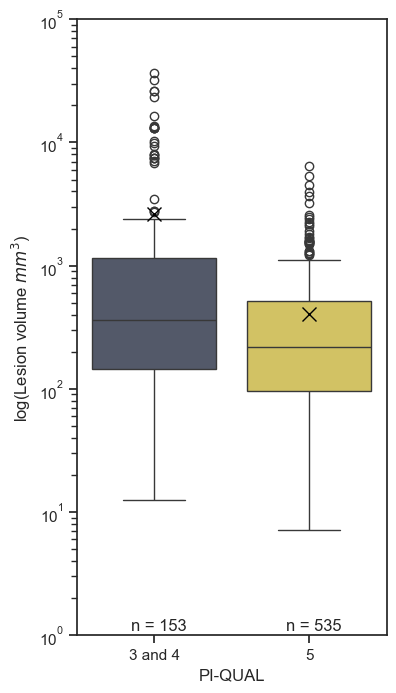

In [22]:
lesion_volumes_no_missing_3and4_vs_5 = lesion_volumes_no_missing.copy()

for lesion in lesion_volumes_no_missing_3and4_vs_5.index:
    if lesion_volumes_no_missing_3and4_vs_5.loc[lesion,'PI-QUAL'] != 5:
        lesion_volumes_no_missing_3and4_vs_5.loc[lesion,'PI-QUAL'] = '3 and 4'

path = 'figures_volume_calculation/PI_QUAL_3and4vs5.svg'
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(4,8))

#Create boxplots:
sns.set_theme(style="ticks")

sns.boxplot(ax=ax, x="PI-QUAL", y="volume_mm3", whis=1.5,showmeans=True, palette=[piqual_3_and_4_color,piqual5_color],
                        meanprops={"marker":"x",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},  data=lesion_volumes_no_missing_3and4_vs_5)


number_piqual_not_5 = lesion_volumes_no_missing_3and4_vs_5.loc[(lesion_volumes_no_missing_3and4_vs_5['PI-QUAL'] == '3 and 4')].shape[0]
number_piqual_5 = lesion_volumes_no_missing.loc[(lesion_volumes_no_missing['PI-QUAL'] == 5)].shape[0]

label = ['n = ' + str(number_piqual_not_5), 'n = ' + str(number_piqual_5)]

# Text at each boxplot:
plt.text(x = -0.15, y = 1.1, s = label[0], size = 12)
plt.text(x = -0.15+1, y = 1.1, s = label[1], size = 12)


plt.yscale('log')
plt.ylim([1,100000])
plt.ylabel(r'log(Lesion volume $mm^3$)')


plt.savefig(path, format='svg',bbox_inches='tight')

#--------------------------------------------------------------------------------------

#basic statistics:


piqual_not_5 = lesion_volumes_no_missing.loc[(lesion_volumes_no_missing['PI-QUAL'] != 5)]
piqual_5 = lesion_volumes_no_missing.loc[(lesion_volumes_no_missing['PI-QUAL'] == 5)]

print('means: sd_piqual not 5:', confidence_interval_mean(piqual_not_5['volume_mm3']),  ' sd_piqual5: ', confidence_interval_mean(piqual_5['volume_mm3']))
print('medians: sd_piqual not 5:', confidence_interval_median(piqual_not_5['volume_mm3']), ' sd_piqual5: ', confidence_interval_median(piqual_5['volume_mm3']))
print('\n')
#check for distribution type:

print(scipy.stats.anderson(piqual_not_5['volume_mm3'],dist='norm'))
print(scipy.stats.anderson(piqual_5['volume_mm3'],dist='norm'))
#--> no normal distributions

print('\n')

#Kruskal Wallis for any number of distributions:
print(scipy.stats.kruskal(piqual_not_5['volume_mm3'], piqual_5['volume_mm3'], nan_policy='propagate', axis=0, keepdims=False))

#Mann-Whitney:
#change the table for this comparison:
lesion_volumes_3_4_vs_5 = lesion_volumes_no_missing.copy()
for lesion in lesion_volumes_3_4_vs_5.index:
    if lesion_volumes_3_4_vs_5.loc[lesion,'PI-QUAL'] != 5:
        lesion_volumes_3_4_vs_5.loc[lesion,'PI-QUAL'] = '3_and_4'
    else:
        lesion_volumes_3_4_vs_5.loc[lesion,'PI-QUAL'] = '5'

pg.pairwise_tests(data=lesion_volumes_3_4_vs_5,dv='volume_mm3',alpha=0.05,parametric=False,between='PI-QUAL',padjust='bonf',effsize='cohen',alternative='two-sided')
#bonferroni_corrected_alpha = 0.05/3
#print(p_values < bonferroni_corrected_alpha)

# Statistical Significance testing Guide:

#1 Check for Normal Distribution and calculate the variances:

In [23]:
#Check whether the data follows a Gaussian distribution: Anderson test to check for normal distribution:
# print(scipy.stats.anderson(Pi_qual_5['volume_mm3'],dist='norm'))

# #when the resulting statistic value is larger than any if the critical values, then it is not! normally distributed. Else it is 
# #with a significance level of e.g. 1%

# #calcualte mean and median of the distributions:
# print('sd_piqual3: ', confidence_interval_mean(Pi_qual_3['volume_mm3']), ' sd_piqual4: ', confidence_interval_mean(Pi_qual_4['volume_mm3']), ' sd_piqual5: ', confidence_interval_mean(Pi_qual_5['volume_mm3']))
# print('sd_piqual3: ', confidence_interval_median(Pi_qual_3['volume_mm3']), ' sd_piqual4: ', confidence_interval_median(Pi_qual_4['volume_mm3']), ' sd_piqual5: ', confidence_interval_median(Pi_qual_5['volume_mm3']))

# #check the variance of the distributions:
# print(stats.variance([1,2,2,3,3,3,4,4,5]))

#2 If Normal distribution. Perform one-way ANOVA and Turkey's HSD posthoc:

In [24]:
#https://www.biostathandbook.com/kruskalwallis.html epic page

# import pingouin as pg
# #the t-tests test the hypotheiss that the population mean of the two groups are the same!
# pg.ttest(Pi_qual_3['volume_mm3'], Pi_qual_5['volume_mm3'], paired=False, alternative='greater')
# print('cohens d:', effect_size(Pi_qual_not_5['volume_mm3'],Pi_qual_5['volume_mm3']))
# #--------------------------------------------------------------------------------
# #In multiple testing with normal distributions and equal variance, check for significant difference:
# scipy.stats.f_oneway(Pi_qual_not_5['volume_mm3'],Pi_qual_not_4['volume_mm3'],Pi_qual_5['volume_mm3'])


# #In multiple testing with normal distributions and equal variance, the Tukey's HSD test (posthoc)for equality of means is used:
# result_anova = scipy.stats.tukey_hsd(Pi_qual_not_5['volume_mm3'],Pi_qual_not_4['volume_mm3'],Pi_qual_5['volume_mm3'])
# result_anova.pvalue



#3 If non-parametric distribution. Perform Wilcoxon rank-sum or Kruskal-Wallis and Dunn-Bonferroni posthoc:

In [25]:
#The kruskal-Wallis test the hypothesis that thepopulation median of all groups are the same!

# #Kruskal Wallis for any number of distributions:
# print(scipy.stats.kruskal(Pi_qual_3['volume_mm3'],Pi_qual_4['volume_mm3'], Pi_qual_5['volume_mm3'], nan_policy='propagate', axis=0, keepdims=False))

# #effect size: Phi from the H-statistic:


# #if the Kruskal-Wallis test indicates a significance, the Dunn's multiple comparison/posthoc test is used:
# #IT tells wheter the medians of the two distributions are significantly different!
# p_values= sp.posthoc_dunn([Pi_qual_3['volume_mm3'],Pi_qual_4['volume_mm3'],Pi_qual_5['volume_mm3']])
# print(p_values)

# #use the pairwise test to calculate the effect size:
# pg.pairwise_tests(data=lesion_volumes_no_missing,dv='volume_mm3',alpha=0.05,parametric=False,between='PI-QUAL',padjust='bonf',effsize='cohen',alternative='two-sided')
# #,padjust='bonf'
# #bonferroni_corrected_alpha = 0.05/3
# #print(p_values < bonferroni_corrected_alpha)

# Plot the Lesion volumes of different readers against piqual

2024-04-22 18:39:25,596:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-04-22 18:39:25,607:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


piqual_3_AI mean  (7249.905, array([ 4248.01406125, 10596.72938886])) median:  (738.824, array([ 199.40183818, 2721.13033177]))
piqual_3_AI mean  (813.755, array([ 410.77988583, 1330.89157073])) median:  (247.49, array([216.3925005, 553.1615996]))
piqual_3_AI mean  (384.278, array([274.55970603, 511.42203825])) median:  (227.509, array([190.84165826, 318.94287719]))
piqual_3_AI mean  (2182.989, array([ 725.04775202, 3889.75242473])) median:  (618.299, array([ 201.19466486, 1781.77202123]))
piqual_3_AI mean  (3534.674, array([1912.08065618, 5319.76958253])) median:  (815.599, array([ 313.25946622, 2404.82921333]))
piqual_3_AI mean  (1406.462, array([ 723.09675531, 2196.1542579 ])) median:  (426.621, array([261.33800773, 901.26556323]))
piqual_3_AI mean  (449.206, array([370.48262069, 534.54428611])) median:  (172.714, array([147.54345777, 224.03503094]))
piqual_3_AI mean  (402.998, array([349.59143326, 462.41607827])) median:  (301.756, array([239.5447674 , 337.27314033]))
piqual_3_AI m

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'AI-Tool_3' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.


,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,cohen
0,anot_piqual,AI-Tool_3,AI-Tool_4,False,False,248.0,two-sided,0.454600,1.000000,bonf,0.543468
1,anot_piqual,AI-Tool_3,AI-Tool_5,False,False,4920.0,two-sided,0.002975,0.107097,bonf,1.830524
2,anot_piqual,AI-Tool_3,Assisted_3,False,False,508.0,two-sided,0.264542,1.000000,bonf,0.807512
3,anot_piqual,AI-Tool_3,Assisted_4,False,False,319.0,two-sided,0.910895,1.000000,bonf,0.413786
4,anot_piqual,AI-Tool_3,Assisted_5,False,False,3177.0,two-sided,0.051988,1.000000,bonf,1.604053
5,anot_piqual,AI-Tool_3,Manual_3,False,False,647.0,two-sided,0.116527,1.000000,bonf,0.912921
6,anot_piqual,AI-Tool_3,Manual_4,False,False,427.0,two-sided,0.520362,1.000000,bonf,0.707498
7,anot_piqual,AI-Tool_3,Manual_5,False,False,2521.0,two-sided,0.019676,0.708344,bonf,1.447981
8,anot_piqual,AI-Tool_4,AI-Tool_5,False,False,2170.0,two-sided,0.062090,1.000000,bonf,1.529088
9,anot_piqual,AI-Tool_4,Assisted_3,False,False,224.0,two-sided,0.463103,1.000000,bonf,0.553653


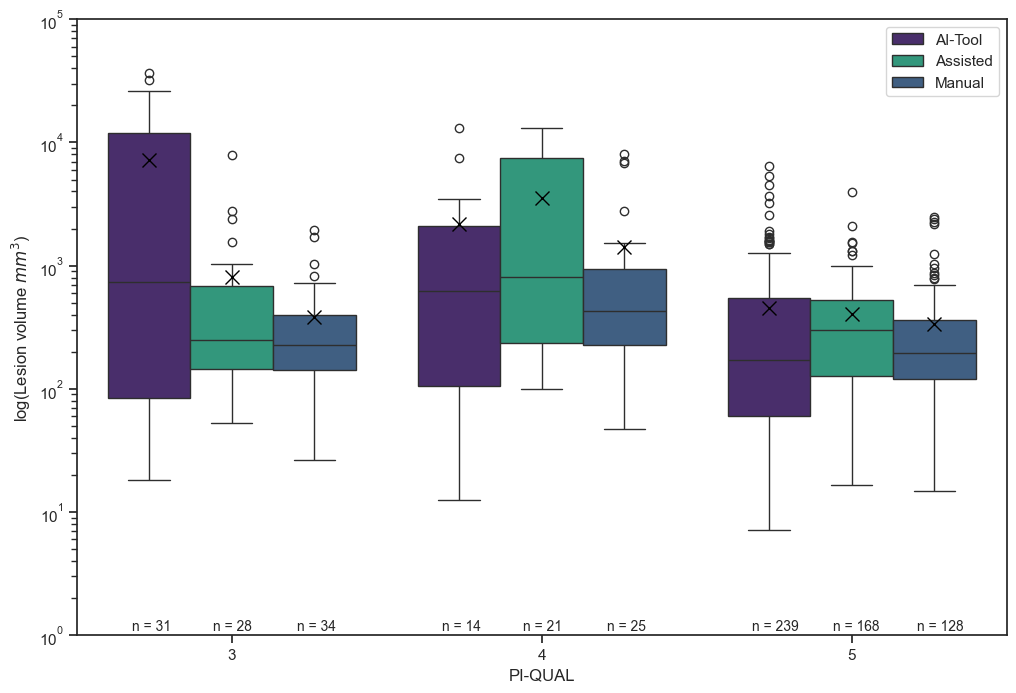

In [26]:
fig, (ax1) = plt.subplots(nrows=1,ncols=1,figsize=(12,8))

#Create boxplots:
sns.set_theme(style="ticks")

sns.boxplot(ax=ax1, x="PI-QUAL", y="volume_mm3", whis=1.5,showmeans=True, palette=[ai_color,assisted_color,manual_color], hue='annotation_type',
                        meanprops={"marker":"x",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},  data=lesion_volumes_no_missing)


ax1.set_yscale('log')
ax1.set_ylim([1,100000])
ax1.set_ylabel(r'log(Lesion volume $mm^3$)')
#ax1.legend(['AI-tool','AI-assisted','manual'])
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles=handles[0:], labels=labels[0:])

#Plot the number of lesions in each boxplot:
piqual_3_AI = lesion_volumes_no_missing.loc[(lesion_volumes_no_missing['PI-QUAL'] == 3) & (lesion_volumes_no_missing['annotation_type'] == 'AI-Tool')]
piqual_3_ass = lesion_volumes_no_missing.loc[(lesion_volumes_no_missing['PI-QUAL'] == 3) & (lesion_volumes_no_missing['annotation_type'] == 'Assisted')]
piqual_3_manual = lesion_volumes_no_missing.loc[(lesion_volumes_no_missing['PI-QUAL'] == 3) & (lesion_volumes_no_missing['annotation_type'] == 'Manual')]

piqual_4_AI = lesion_volumes_no_missing.loc[(lesion_volumes_no_missing['PI-QUAL'] == 4) & (lesion_volumes_no_missing['annotation_type'] == 'AI-Tool')]
piqual_4_ass = lesion_volumes_no_missing.loc[(lesion_volumes_no_missing['PI-QUAL'] == 4) & (lesion_volumes_no_missing['annotation_type'] == 'Assisted')]
piqual_4_manual = lesion_volumes_no_missing.loc[(lesion_volumes_no_missing['PI-QUAL'] == 4) & (lesion_volumes_no_missing['annotation_type'] == 'Manual')]

piqual_5_AI = lesion_volumes_no_missing.loc[(lesion_volumes_no_missing['PI-QUAL'] == 5) & (lesion_volumes_no_missing['annotation_type'] == 'AI-Tool')]
piqual_5_ass = lesion_volumes_no_missing.loc[(lesion_volumes_no_missing['PI-QUAL'] == 5) & (lesion_volumes_no_missing['annotation_type'] == 'Assisted')]
piqual_5_manual = lesion_volumes_no_missing.loc[(lesion_volumes_no_missing['PI-QUAL'] == 5) & (lesion_volumes_no_missing['annotation_type'] == 'Manual')]

plt.text(x = -0.32, y = 1.1, s = f"n = {piqual_3_AI.shape[0]}", size = 10)
plt.text(x = -0.32+0.25+0.01, y = 1.1, s = f"n = {piqual_3_ass.shape[0]}", size = 10)
plt.text(x = -0.32+2*0.25+0.03, y = 1.1, s = f"n = {piqual_3_manual.shape[0]}", size = 10)

plt.text(x = -0.32+4*0.25, y = 1.1, s = f"n = {piqual_4_AI.shape[0]}", size = 10)
plt.text(x = -0.32+5*0.25+0.01, y = 1.1, s = f"n = {piqual_4_ass.shape[0]}", size = 10)
plt.text(x = -0.32+6*0.25+0.03, y = 1.1, s = f"n = {piqual_4_manual.shape[0]}", size = 10)

plt.text(x = -0.32+8*0.25, y = 1.1, s = f"n = {piqual_5_AI.shape[0]}", size = 10)
plt.text(x = -0.32+9*0.25+0.01, y = 1.1, s = f"n = {piqual_5_ass.shape[0]}", size = 10)
plt.text(x = -0.32+10*0.25+0.03, y = 1.1, s = f"n = {piqual_5_manual.shape[0]}", size = 10)


path = 'figures_volume_calculation/PI_QUAL_annotation_types.svg'
plt.savefig(path, format='svg',bbox_inches='tight')

#----------------------------------------------------------------------------------------------------------------------
#basic statistics:

print('piqual_3_AI mean ', confidence_interval_mean(piqual_3_AI['volume_mm3']),'median: ',confidence_interval_median(piqual_3_AI['volume_mm3']))
print('piqual_3_AI mean ', confidence_interval_mean(piqual_3_ass['volume_mm3']),'median: ',confidence_interval_median(piqual_3_ass['volume_mm3']))
print('piqual_3_AI mean ', confidence_interval_mean(piqual_3_manual['volume_mm3']),'median: ',confidence_interval_median(piqual_3_manual['volume_mm3']))

print('piqual_3_AI mean ', confidence_interval_mean(piqual_4_AI['volume_mm3']),'median: ',confidence_interval_median(piqual_4_AI['volume_mm3']))
print('piqual_3_AI mean ', confidence_interval_mean(piqual_4_ass['volume_mm3']),'median: ',confidence_interval_median(piqual_4_ass['volume_mm3']))
print('piqual_3_AI mean ', confidence_interval_mean(piqual_4_manual['volume_mm3']),'median: ',confidence_interval_median(piqual_4_manual['volume_mm3']))

print('piqual_3_AI mean ', confidence_interval_mean(piqual_5_AI['volume_mm3']),'median: ',confidence_interval_median(piqual_5_AI['volume_mm3']))
print('piqual_3_AI mean ', confidence_interval_mean(piqual_5_ass['volume_mm3']),'median: ',confidence_interval_median(piqual_5_ass['volume_mm3']))
print('piqual_3_AI mean ', confidence_interval_mean(piqual_5_manual['volume_mm3']),'median: ',confidence_interval_median(piqual_5_manual['volume_mm3']))
print('\n')
#check for distribution type:

print(scipy.stats.anderson(piqual_5_manual['volume_mm3'],dist='norm'))

#--> no normal distributions

print('\n')

#Kruskal Wallis for any number of distributions:
print(scipy.stats.kruskal(piqual_3_AI['volume_mm3'], 
                          piqual_3_ass['volume_mm3'],
                          piqual_3_manual['volume_mm3'],
                          piqual_4_AI['volume_mm3'],
                          piqual_4_ass['volume_mm3'],
                          piqual_4_manual['volume_mm3'],
                          piqual_5_AI['volume_mm3'],
                          piqual_5_ass['volume_mm3'],
                          piqual_5_manual['volume_mm3'],
                          nan_policy='propagate', axis=0, keepdims=False))

#Mann-Whitney:
#change the table for this comparison:
lesion_volumes_piqual_annotation_type = lesion_volumes_no_missing.copy()
lesion_volumes_piqual_annotation_type['anot_piqual'] = 0

for lesion in lesion_volumes_piqual_annotation_type.index:
    newname = f"{lesion_volumes_piqual_annotation_type.loc[lesion,'annotation_type']}_{lesion_volumes_piqual_annotation_type.loc[lesion,'PI-QUAL']}"
    lesion_volumes_piqual_annotation_type.loc[lesion,'anot_piqual'] = newname


pg.pairwise_tests(data=lesion_volumes_piqual_annotation_type,dv='volume_mm3',alpha=0.05,parametric=False,between='anot_piqual',padjust='bonf',effsize='cohen',alternative='two-sided')
#bonferroni_corrected_alpha = 0.05/3
#print(p_values < bonferroni_corrected_alpha)

# Compare Lesion volumes bewteen AI-Tool, AI-assisted and manual annotation:

In [27]:
cmap = plt.cm.get_cmap('viridis')
ai_color = cmap(0.1)
manual_color = cmap(0.3)
assisted_color = cmap(0.6)

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



ai mean  (1489.944, array([ 991.18959641, 2056.00620084])) median:  (207.504, array([160.62423474, 268.44726175]))
ass mean  (773.71, array([581.72402698, 993.22880472])) median:  (313.259, array([261.29195789, 354.06417335]))
manual mean  (513.976, array([407.30814609, 637.13964095])) median:  (229.752, array([200.33100362, 260.03977642]))
AndersonResult(statistic=77.73964858880368, critical_values=array([0.568, 0.647, 0.776, 0.906, 1.077]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=1489.944467488306, scale=5576.320588818398)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
AndersonResult(statistic=50.319938299196, critical_values=array([0.566, 0.645, 0.774, 0.902, 1.073]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=773.7103150377892, scale=1870.125748814114)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Ander

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,cohen
0,annotation_type,AI-Tool,Assisted,False,False,27045.0,two-sided,0.003951,0.011852,bonf,0.164371
1,annotation_type,AI-Tool,Manual,False,False,25620.5,two-sided,0.102938,0.308815,bonf,0.225139
2,annotation_type,Assisted,Manual,False,False,24215.5,two-sided,0.069991,0.209972,bonf,0.170902


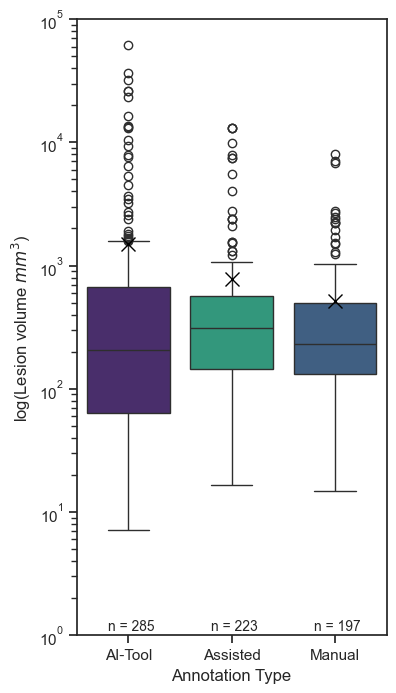

In [28]:
fig, (ax1) = plt.subplots(nrows=1,ncols=1,figsize=(4,8))


sns.boxplot(ax=ax1, x="annotation_type", y="volume_mm3", whis=1.5,showmeans=True, palette=[ai_color,assisted_color,manual_color],
                        meanprops={"marker":"x",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},  data=lesion_volumes)

ax1.set_yscale('log')
ax1.set_ylim([1,100000])
ax1.set_ylabel(r'log(Lesion volume $mm^3$)')
ax1.set_xlabel(r'Annotation Type')

ai = lesion_volumes.loc[(lesion_volumes['annotation_type'] == 'AI-Tool')]
ass = lesion_volumes.loc[(lesion_volumes['annotation_type'] == 'Assisted')]
manual = lesion_volumes.loc[(lesion_volumes['annotation_type'] == 'Manual')]

# Text at each boxplot:
plt.text(x = -0.2, y = 1.1, s = f"n = {ai.shape[0]}", size = 10)
plt.text(x = -0.2+1, y = 1.1, s = f"n = {ass.shape[0]}", size = 10)
plt.text(x = -0.2+2, y = 1.1, s = f"n = {manual.shape[0]}", size = 10)

path = 'figures_volume_calculation/Annotation_types.svg'
plt.savefig(path, format='svg',bbox_inches='tight')
#-------------------------------------------------------------------------
print('ai mean ', confidence_interval_mean(ai['volume_mm3']),'median: ',confidence_interval_median(ai['volume_mm3']))
print('ass mean ', confidence_interval_mean(ass['volume_mm3']),'median: ',confidence_interval_median(ass['volume_mm3']))
print('manual mean ', confidence_interval_mean(manual['volume_mm3']),'median: ',confidence_interval_median(manual['volume_mm3']))

#check for distribution type:

print(scipy.stats.anderson(ai['volume_mm3'],dist='norm'))
print(scipy.stats.anderson(ass['volume_mm3'],dist='norm'))
print(scipy.stats.anderson(manual['volume_mm3'],dist='norm'))

#--> no normal distributions

print('\n')

#Kruskal Wallis for any number of distributions:
print(scipy.stats.kruskal(ai['volume_mm3'],ass['volume_mm3'],manual['volume_mm3'],nan_policy='propagate', axis=0, keepdims=False))


#Mann-Whitney:

print(pg.pairwise_tests(data=lesion_volumes,dv='volume_mm3',alpha=0.05,parametric=False,between='annotation_type',padjust='bonf',effsize='cohen',alternative='greater'))
pg.pairwise_tests(data=lesion_volumes,dv='volume_mm3',alpha=0.05,parametric=False,between='annotation_type',padjust='bonf',effsize='cohen',alternative='two-sided')

# Intraeader Variability

In [29]:
lesion_volumes['Annotator'] = 0
for lesion in lesion_volumes.index:
    lesion_volumes.loc[lesion,'Annotator'] = lesion_volumes.loc[lesion,'reader'] + '_' + lesion_volumes.loc[lesion,'annotation_type']

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'pcai100_AI-Tool' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.


set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


AndersonResult(statistic=77.73964858880368, critical_values=array([0.568, 0.647, 0.776, 0.906, 1.077]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=1489.944467488306, scale=5576.320588818398)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
AndersonResult(statistic=14.706941046682601, critical_values=array([0.55 , 0.626, 0.751, 0.876, 1.042]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=970.0288793093197, scale=1954.4966552983701)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
AndersonResult(statistic=5.234983980277299, critical_values=array([0.534, 0.609, 0.73 , 0.852, 1.013]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=1343.5589175323628, scale=1804.4961053312702)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
AndersonResult(

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,cohen
0,Annotator,pcai100_AI-Tool,rad1_Assisted,False,False,7841.0,two-sided,1.216107e-04,2.553824e-03,bonf,0.103289
1,Annotator,pcai100_AI-Tool,rad1_Manual,False,False,3515.5,two-sided,2.735469e-06,5.744484e-05,bonf,0.027948
2,Annotator,pcai100_AI-Tool,rad2_Assisted,False,False,9388.0,two-sided,6.900777e-01,1.000000e+00,bonf,0.174409
3,Annotator,pcai100_AI-Tool,rad2_Manual,False,False,9581.0,two-sided,8.132258e-01,1.000000e+00,bonf,0.237997
4,Annotator,pcai100_AI-Tool,rad3_Assisted,False,False,9816.0,two-sided,1.138102e-01,1.000000e+00,bonf,0.151905
5,Annotator,pcai100_AI-Tool,rad3_Manual,False,False,12524.0,two-sided,8.858762e-01,1.000000e+00,bonf,0.251175
6,Annotator,rad1_Assisted,rad1_Manual,False,False,1292.0,two-sided,3.051428e-02,6.407999e-01,bonf,-0.196423
7,Annotator,rad1_Assisted,rad2_Assisted,False,False,3499.0,two-sided,4.855722e-04,1.019702e-02,bonf,0.194867
8,Annotator,rad1_Assisted,rad2_Manual,False,False,3670.0,two-sided,4.882449e-06,1.025314e-04,bonf,0.467707
9,Annotator,rad1_Assisted,rad3_Assisted,False,False,3747.5,two-sided,7.752192e-03,1.627960e-01,bonf,0.127001


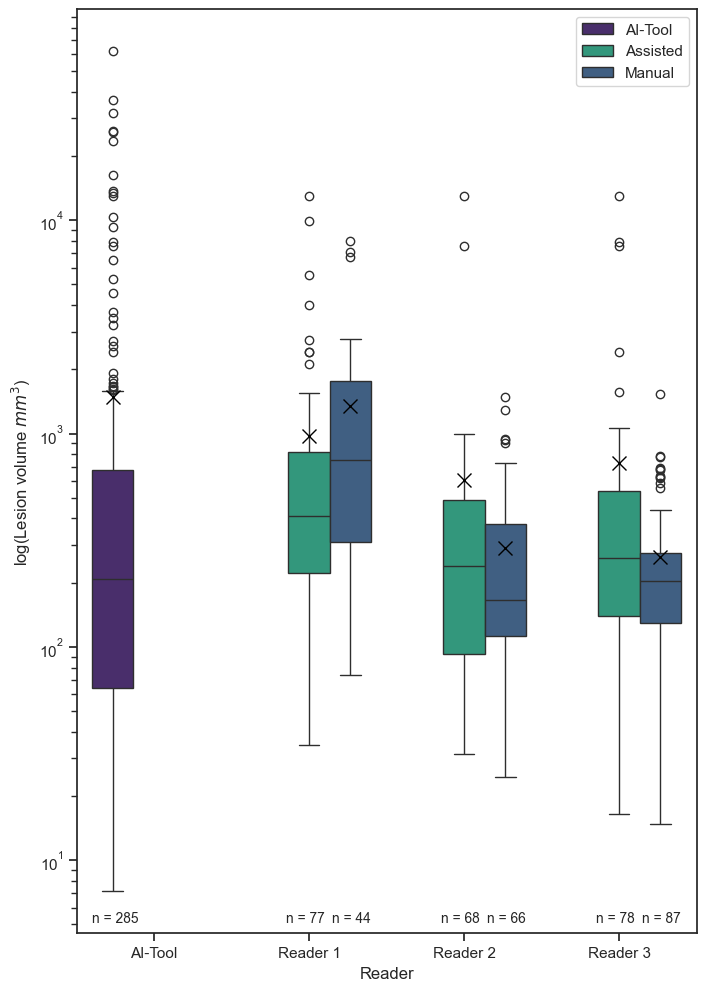

In [30]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(8,12))

#Create boxplots:
sns.set_theme(style="ticks")

sns.boxplot(ax=ax, x="reader", y="volume_mm3", whis=1.5,showmeans=True, palette=[ai_color,assisted_color,manual_color], hue='annotation_type',
                        meanprops={"marker":"x",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},  data=lesion_volumes)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:])
ax.set_xticklabels(['AI-Tool','Reader 1','Reader 2', 'Reader 3'])

plt.yscale('log')
plt.ylabel(r'log(Lesion volume $mm^3$)')
ax.set_xlabel(r'Reader')

ai = lesion_volumes.loc[(lesion_volumes['annotation_type'] == 'AI-Tool') & (lesion_volumes['reader'] == 'pcai100')]
reader1_assisted = lesion_volumes.loc[(lesion_volumes['annotation_type'] == 'Assisted') & (lesion_volumes['reader'] == 'rad1')]
reader1_manual = lesion_volumes.loc[(lesion_volumes['annotation_type'] == 'Manual') & (lesion_volumes['reader'] == 'rad1')]
reader2_assisted = lesion_volumes.loc[(lesion_volumes['annotation_type'] == 'Assisted') & (lesion_volumes['reader'] == 'rad2')]
reader2_manual = lesion_volumes.loc[(lesion_volumes['annotation_type'] == 'Manual') & (lesion_volumes['reader'] == 'rad2')]
reader3_assisted = lesion_volumes.loc[(lesion_volumes['annotation_type'] == 'Assisted') & (lesion_volumes['reader'] == 'rad3')]
reader3_manual = lesion_volumes.loc[(lesion_volumes['annotation_type'] == 'Manual') & (lesion_volumes['reader'] == 'rad3')]

plt.text(x = -0.4, y = 5.1, s = f"n = {ai.shape[0]}", size = 10)
plt.text(x = -0.4+1.25, y = 5.1, s = f"n = {reader1_assisted.shape[0]}", size = 10)
plt.text(x = -0.4+1.25+0.3, y = 5.1, s = f"n = {reader1_manual.shape[0]}", size = 10)
plt.text(x = -0.4+2.25, y = 5.1, s = f"n = {reader2_assisted.shape[0]}", size = 10)
plt.text(x = -0.4+2.25+0.3, y = 5.1, s = f"n = {reader2_manual.shape[0]}", size = 10)
plt.text(x = -0.4+3.25, y = 5.1, s = f"n = {reader3_assisted.shape[0]}", size = 10)
plt.text(x = -0.4+3.25+0.3, y = 5.1, s = f"n = {reader3_manual.shape[0]}", size = 10)

path = 'figures_volume_calculation/lesion_volume_intrareader_variability.png'
plt.savefig(path, format='png',bbox_inches='tight')

#-------------------------------------------------------------------------

#check for distribution type:

print(scipy.stats.anderson(ai['volume_mm3'],dist='norm'))
print(scipy.stats.anderson(reader1_assisted['volume_mm3'],dist='norm'))
print(scipy.stats.anderson(reader1_manual['volume_mm3'],dist='norm'))
print(scipy.stats.anderson(reader2_assisted['volume_mm3'],dist='norm'))
print(scipy.stats.anderson(reader2_manual['volume_mm3'],dist='norm'))
print(scipy.stats.anderson(reader3_assisted['volume_mm3'],dist='norm'))
print(scipy.stats.anderson(reader3_manual['volume_mm3'],dist='norm'))

#--> no normal distributions

print('\n')

#Kruskal Wallis for any number of distributions:
print(scipy.stats.kruskal(ai['volume_mm3'],reader1_assisted['volume_mm3'],reader1_manual['volume_mm3'],
                          reader2_assisted['volume_mm3'],reader2_manual['volume_mm3'],
                          reader3_assisted['volume_mm3'],reader3_manual['volume_mm3'],nan_policy='propagate', axis=0, keepdims=False))


#Mann-Whitney:

pg.pairwise_tests(data=lesion_volumes,dv='volume_mm3',alpha=0.05,parametric=False,between='Annotator',padjust='bonf',effsize='cohen',alternative='two-sided')

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


AndersonResult(statistic=14.706941046682601, critical_values=array([0.55 , 0.626, 0.751, 0.876, 1.042]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=970.0288793093197, scale=1954.4966552983701)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
AndersonResult(statistic=5.234983980277299, critical_values=array([0.534, 0.609, 0.73 , 0.852, 1.013]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=1343.5589175323628, scale=1804.4961053312702)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
AndersonResult(statistic=17.622565802230383, critical_values=array([0.547, 0.623, 0.747, 0.871, 1.037]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=604.6625131566881, scale=1780.4240232326458)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
AndersonResul

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,cohen
0,Annotator,rad1_Assisted,rad1_Manual,False,False,1292.0,two-sided,3.051428e-02,4.577142e-01,bonf,-0.196423
1,Annotator,rad1_Assisted,rad2_Assisted,False,False,3499.0,two-sided,4.855722e-04,7.283583e-03,bonf,0.194867
2,Annotator,rad1_Assisted,rad2_Manual,False,False,3670.0,two-sided,4.882449e-06,7.323674e-05,bonf,0.467707
3,Annotator,rad1_Assisted,rad3_Assisted,False,False,3747.5,two-sided,7.752192e-03,1.162829e-01,bonf,0.127001
4,Annotator,rad1_Assisted,rad3_Manual,False,False,4883.5,two-sided,4.354722e-07,6.532083e-06,bonf,0.524585
5,Annotator,rad1_Manual,rad2_Assisted,False,False,2276.0,two-sided,3.418246e-06,5.127370e-05,bonf,0.412821
6,Annotator,rad1_Manual,rad2_Manual,False,False,2324.0,two-sided,1.052684e-07,1.579026e-06,bonf,0.905039
7,Annotator,rad1_Manual,rad3_Assisted,False,False,2482.0,two-sided,4.476440e-05,6.714660e-04,bonf,0.333958
8,Annotator,rad1_Manual,rad3_Manual,False,False,3141.0,two-sided,2.272460e-09,3.408690e-08,bonf,1.021904
9,Annotator,rad2_Assisted,rad2_Manual,False,False,2403.0,two-sided,4.805703e-01,1.000000e+00,bonf,0.242976


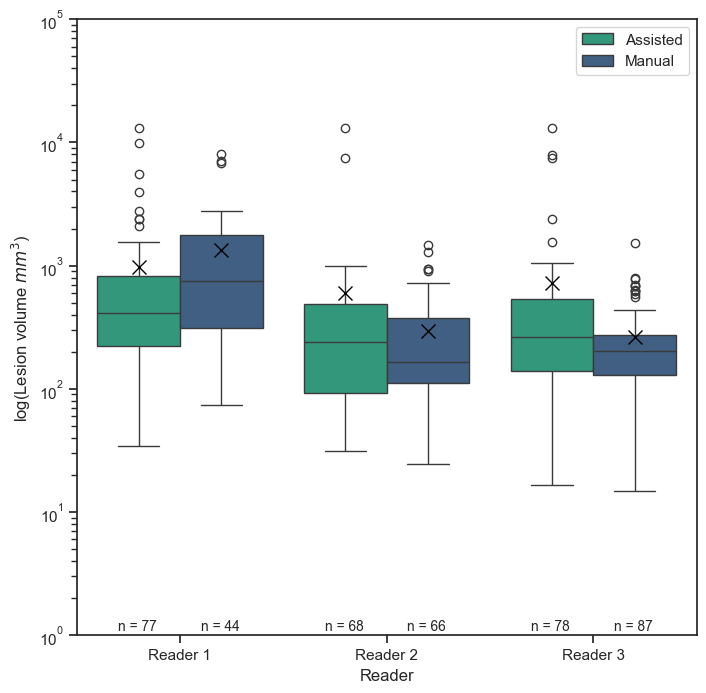

In [31]:
#get only the non-ai lesions:
lesion_volumes_no_ai = lesion_volumes.copy()
for lesion in lesion_volumes_no_ai.index:
    if lesion_volumes_no_ai.loc[lesion,'annotation_type'] == 'AI-Tool':
        lesion_volumes_no_ai.drop(index=lesion,inplace=True)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))

#Create boxplots:
sns.set_theme(style="ticks")

sns.boxplot(ax=ax, x="reader", y="volume_mm3", whis=1.5,showmeans=True, palette=[assisted_color,manual_color], hue='annotation_type',
                        meanprops={"marker":"x",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},  data=lesion_volumes_no_ai)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:])
ax.set_xticklabels(['Reader 1','Reader 2', 'Reader 3'])

plt.yscale('log')
ax.set_ylim([1,100000])
plt.ylabel(r'log(Lesion volume $mm^3$)')
ax.set_xlabel(r'Reader')

reader1_assisted = lesion_volumes.loc[(lesion_volumes['annotation_type'] == 'Assisted') & (lesion_volumes['reader'] == 'rad1')]
reader1_manual = lesion_volumes.loc[(lesion_volumes['annotation_type'] == 'Manual') & (lesion_volumes['reader'] == 'rad1')]
reader2_assisted = lesion_volumes.loc[(lesion_volumes['annotation_type'] == 'Assisted') & (lesion_volumes['reader'] == 'rad2')]
reader2_manual = lesion_volumes.loc[(lesion_volumes['annotation_type'] == 'Manual') & (lesion_volumes['reader'] == 'rad2')]
reader3_assisted = lesion_volumes.loc[(lesion_volumes['annotation_type'] == 'Assisted') & (lesion_volumes['reader'] == 'rad3')]
reader3_manual = lesion_volumes.loc[(lesion_volumes['annotation_type'] == 'Manual') & (lesion_volumes['reader'] == 'rad3')]

plt.text(x = -0.3, y = 1.1, s = f"n = {reader1_assisted.shape[0]}", size = 10)
plt.text(x = -0.3+0.4, y = 1.1, s = f"n = {reader1_manual.shape[0]}", size = 10)
plt.text(x = -0.3+1, y = 1.1, s = f"n = {reader2_assisted.shape[0]}", size = 10)
plt.text(x = -0.3+1+0.4, y = 1.1, s = f"n = {reader2_manual.shape[0]}", size = 10)
plt.text(x = -0.3+2, y = 1.1, s = f"n = {reader3_assisted.shape[0]}", size = 10)
plt.text(x = -0.3+2+0.4, y = 1.1, s = f"n = {reader3_manual.shape[0]}", size = 10)

path = 'figures_volume_calculation/lesion_volume_intrareader_variability_noAI.svg'
plt.savefig(path, format='svg',bbox_inches='tight')

#-------------------------------------------------------------------------

#check for distribution type:

print(scipy.stats.anderson(reader1_assisted['volume_mm3'],dist='norm'))
print(scipy.stats.anderson(reader1_manual['volume_mm3'],dist='norm'))
print(scipy.stats.anderson(reader2_assisted['volume_mm3'],dist='norm'))
print(scipy.stats.anderson(reader2_manual['volume_mm3'],dist='norm'))
print(scipy.stats.anderson(reader3_assisted['volume_mm3'],dist='norm'))
print(scipy.stats.anderson(reader3_manual['volume_mm3'],dist='norm'))

#--> no normal distributions

print('\n')

#Kruskal Wallis for any number of distributions:
print(scipy.stats.kruskal(reader1_assisted['volume_mm3'],reader1_manual['volume_mm3'],
                          reader2_assisted['volume_mm3'],reader2_manual['volume_mm3'],
                          reader3_assisted['volume_mm3'],reader3_manual['volume_mm3'],nan_policy='propagate', axis=0, keepdims=False))


#Mann-Whitney:

pg.pairwise_tests(data=lesion_volumes_no_ai,dv='volume_mm3',alpha=0.05,parametric=False,between='Annotator',padjust='bonf',effsize='cohen',alternative='two-sided')

# Make a plot with the variances of the different Readers

In [32]:
# #currently we assume normal distirbution here! not very useful

# overview_lesion_volumes = pd.DataFrame(columns=['PI-QUAL','mean','median','Variance','standard_deviation','reader','annot_type','annotator'])

# Readers = ['pcai100_auto','rad1_rad','rad1_ass','rad2_rad','rad2_ass','rad3_rad','rad3_ass']
# PIRADS_scores = [1,2,3,4,5]
# piqual_scores = [3,4,5]


# for Reader in Readers:
#     for piqual_score in piqual_scores:
#         Annot = Reader.split('_')[0]
#         annot_type = Reader.split('_')[1]
#         list_per_piqual_per_Reader = lesion_volumes_no_missing.loc[(lesion_volumes_no_missing['annotation_type'] == annot_type) & (lesion_volumes_no_missing['reader'] == Annot) & (lesion_volumes_no_missing['PI-QUAL'] == piqual_score)]
#         rowname = f"{Reader}_{piqual_score}"
#         mean_volume = stats.mean(list(list_per_piqual_per_Reader['volume_mm3']))
#         median_volume = stats.median(list(list_per_piqual_per_Reader['volume_mm3']))
#         var = stats.variance(list(list_per_piqual_per_Reader['volume_mm3']))
#         sd = stats.stdev(list(list_per_piqual_per_Reader['volume_mm3']))
#         overview_lesion_volumes.loc[rowname] = [piqual_score,mean_volume,median_volume,var,sd,Reader.split('_')[0],annot_type,Reader]


In [33]:
# fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))

# #Create boxplots:
# sns.set_theme(style="ticks")

# sns.boxplot(ax=ax, x="annot_type", y="standard_deviation", palette='colorblind', data=overview_lesion_volumes)

# plt.yscale('log')
# plt.ylabel([0,10000])
# plt.ylabel(r'log(Standard Deviation of Lesion volume $mm^3$)')

In [34]:
# fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(12,6))

# #Create boxplots:
# sns.set_theme(style="ticks")

# sns.boxplot(ax=ax1, x="PI-QUAL", y="standard_deviation", palette='colorblind',hue='annot_type', data=overview_lesion_volumes)

# ax1.set_yscale('log')
# ax1.set_ylabel(r'log(Standard Deviation of Lesion volume $mm^3$)')

# sns.boxplot(ax=ax2, x="PI-QUAL", y="standard_deviation", palette='colorblind',hue='reader', data=overview_lesion_volumes)

# ax2.set_yscale('log')
# ax2.set_ylabel(r'log(Standard Deviation of Lesion volume $mm^3$)')

# Volume comparison between positive and negative lesions

In [35]:
#import from the general calculations the file with lesionqise gleason score
lesions_with_gleason =  pd.read_excel(r"C:\Users\Joel Fischer\Documents\Masterarbeit\Studie\Projekt\Auswertungsdaten\Benchmark\Lesion_wise_analysis\volume_gleason.xlsx")
lesions_with_gleason.index = lesions_with_gleason['Unnamed: 0']

In [36]:
#add the gleason scoer to each lesion:
lesion_volumes['Gleason'] = ''

for lesion in lesion_volumes.index:
    case = lesion.split('_')[0].split('-')[0] + '_' + lesion.split('_')[0].split('-')[1]
    reader = lesion.split('_')[-2].split('.')[0]
    ann_type = lesion.split('_')[-1].split('.')[0]
    score = lesion.split('_')[2].split('-')[1]
    rowname = f"{case}_les-{score}_{reader}_{ann_type}_t2w"
    lesion_volumes.loc[lesion,'Gleason'] = lesions_with_gleason.loc[rowname,'Gleason']

In [37]:
def Gleason_score_to_ISUP(score):
    if score <= 3:
        return 1
    if score == 4:
        return 2
    if score == 6:
        return 3
    if score == 5 or score == 7 or score == 9:
        return 4
    if score == 8 or score == 10 or score == 11:
        return 5

In [38]:
#Add the ISUP Grade Group:
lesion_volumes['ISUP_Grade_Group'] = ''

for lesion in lesion_volumes.index:
    lesion_volumes.loc[lesion, 'ISUP_Grade_Group'] = Gleason_score_to_ISUP(lesion_volumes.loc[lesion, 'Gleason'])

2024-04-22 18:39:45,678:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-04-22 18:39:45,686:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


AndersonResult(statistic=151.82382508972682, critical_values=array([0.572, 0.651, 0.781, 0.911, 1.084]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=674.7469093242966, scale=2757.212239939314)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
AndersonResult(statistic=23.22413520398824, critical_values=array([0.552, 0.629, 0.755, 0.88 , 1.047]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=1807.6987056609828, scale=6889.4967911428585)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
AndersonResult(statistic=5.18685427643393, critical_values=array([0.505, 0.575, 0.69 , 0.804, 0.957]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=2110.0806297531453, scale=5831.245513817196)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
AndersonResult(s

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,cohen
0,ISUP_Grade_Group,1,2,False,False,16127.5,two-sided,7.609735e-07,7.609735e-06,bonf,-0.314520
1,ISUP_Grade_Group,1,3,False,False,2988.0,two-sided,1.385079e-03,1.385079e-02,bonf,-0.494181
2,ISUP_Grade_Group,1,4,False,False,3303.0,two-sided,9.208974e-08,9.208974e-07,bonf,-0.567597
3,ISUP_Grade_Group,1,5,False,False,3425.0,two-sided,5.660795e-02,5.660795e-01,bonf,-1.052384
4,ISUP_Grade_Group,2,3,False,False,713.0,two-sided,3.519343e-01,1.000000e+00,bonf,-0.045009
5,ISUP_Grade_Group,2,4,False,False,794.0,two-sided,2.903872e-03,2.903872e-02,bonf,-0.070706
6,ISUP_Grade_Group,2,5,False,False,707.0,two-sided,7.784629e-01,1.000000e+00,bonf,-0.282405
7,ISUP_Grade_Group,3,4,False,False,205.0,two-sided,1.398908e-01,1.000000e+00,bonf,-0.030974
8,ISUP_Grade_Group,3,5,False,False,168.0,two-sided,8.490958e-01,1.000000e+00,bonf,-0.278374
9,ISUP_Grade_Group,4,5,False,False,286.0,two-sided,3.745728e-01,1.000000e+00,bonf,-0.359001


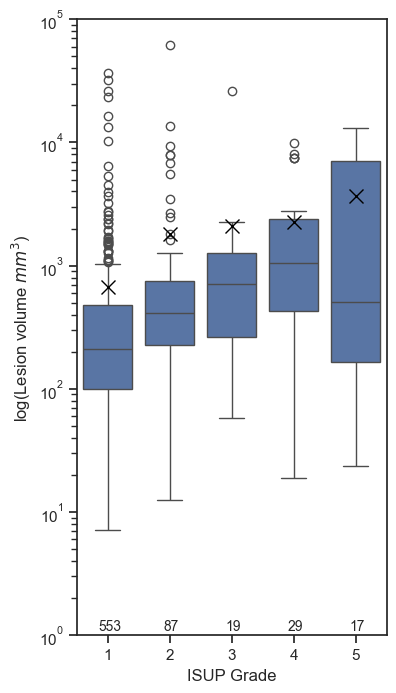

In [39]:
fig, (ax1) = plt.subplots(nrows=1,ncols=1,figsize=(4,8))


sns.boxplot(ax=ax1, x="ISUP_Grade_Group", y="volume_mm3", whis=1.5,showmeans=True,
                        meanprops={"marker":"x",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},  data=lesion_volumes)

ax1.set_yscale('log')
ax1.set_ylim([1,100000])
ax1.set_ylabel(r'log(Lesion volume $mm^3$)')
ax1.set_xlabel(r'ISUP Grade')



Grade1 = lesion_volumes.loc[(lesion_volumes['ISUP_Grade_Group'] == 1)]
Grade2 = lesion_volumes.loc[(lesion_volumes['ISUP_Grade_Group'] == 2)]
Grade3 = lesion_volumes.loc[(lesion_volumes['ISUP_Grade_Group'] == 3)]
Grade4 = lesion_volumes.loc[(lesion_volumes['ISUP_Grade_Group'] == 4)]
Grade5 = lesion_volumes.loc[(lesion_volumes['ISUP_Grade_Group'] == 5)]


#-------------------------------------------------------------------------

#check for distribution type:
print(scipy.stats.anderson(Grade1['volume_mm3'],dist='norm'))
print(scipy.stats.anderson(Grade2['volume_mm3'],dist='norm'))
print(scipy.stats.anderson(Grade3['volume_mm3'],dist='norm'))
print(scipy.stats.anderson(Grade4['volume_mm3'],dist='norm'))
print(scipy.stats.anderson(Grade5['volume_mm3'],dist='norm'))

#--> no normal distributions
plt.text(x = -0.15, y = 1.1, s = f"{Grade1.shape[0]}", size = 10)
plt.text(x = -0.10+1, y = 1.1, s = f"{Grade2.shape[0]}", size = 10)
plt.text(x = -0.10+2, y = 1.1, s = f"{Grade3.shape[0]}", size = 10)
plt.text(x = -0.10+3, y = 1.1, s = f"{Grade4.shape[0]}", size = 10)
plt.text(x = -0.10+4, y = 1.1, s = f"{Grade5.shape[0]}", size = 10)
print('\n')

#Kruskal Wallis for any number of distributions:
print(scipy.stats.kruskal(Grade1['volume_mm3'],Grade2['volume_mm3'],
                          Grade3['volume_mm3'],Grade4['volume_mm3'],
                          Grade5['volume_mm3'],nan_policy='propagate', axis=0, keepdims=False))



path = 'figures_volume_calculation/lesion_volume_ISUP_Grade_Groups.svg'
plt.savefig(path, format='svg',bbox_inches='tight')

#Mann-Whitney:

pg.pairwise_tests(data=lesion_volumes,dv='volume_mm3',alpha=0.05,parametric=False,between='ISUP_Grade_Group',padjust='bonf',effsize='cohen',alternative='two-sided')



# Do the malignant lesion analysis in a binary way:

In [40]:
def malignant_or_not(ISUP_Grade_Group):
    if ISUP_Grade_Group == 1:
        return 0
    if ISUP_Grade_Group > 1:
        return 1

In [41]:
#Add the csPCA or not column:
lesion_volumes['Malignant'] = ''

for lesion in lesion_volumes.index:
    lesion_volumes.loc[lesion, 'Malignant'] = malignant_or_not(lesion_volumes.loc[lesion, 'ISUP_Grade_Group'])

In [42]:
#colormap for malignant:
cmap = plt.cm.get_cmap('inferno')
benign_color = cmap(0.95)
malignant_color = cmap(0.5)


The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


    Contrast  A  B  Paired  Parametric   U-val alternative     p-unc     cohen
0  Malignant  0  1   False       False  3487.0   two-sided  0.001054 -0.505977
ai_tool:  KruskalResult(statistic=10.736018775317419, pvalue=0.0010507014069781617)
    Contrast  A  B  Paired  Parametric   U-val alternative         p-unc  \
0  Malignant  0  1   False       False  2283.0   two-sided  1.843781e-08   

      cohen  
0 -0.919889  
assisted:  KruskalResult(statistic=31.666037389100048, pvalue=1.8309631830032514e-08)
    Contrast  A  B  Paired  Parametric   U-val alternative     p-unc     cohen
0  Malignant  0  1   False       False  2520.0   two-sided  0.000115 -0.695384
manual:  KruskalResult(statistic=14.88556249473283, pvalue=0.000114233926961699)


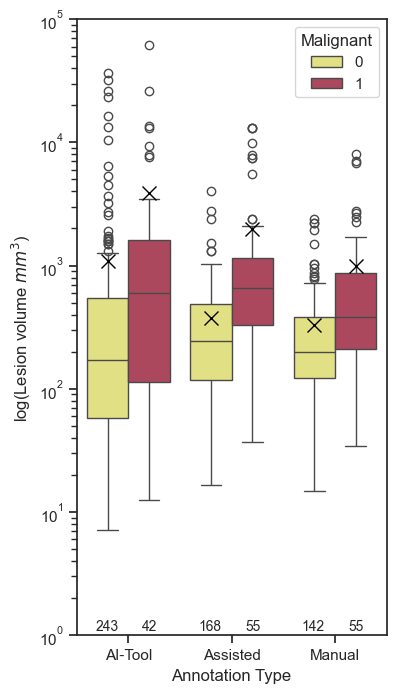

In [43]:
fig, (ax1) = plt.subplots(nrows=1,ncols=1,figsize=(4,8))


sns.boxplot(ax=ax1, x="annotation_type", y="volume_mm3", whis=1.5,showmeans=True, hue='Malignant', palette=[benign_color,malignant_color],
                        meanprops={"marker":"x",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},  data=lesion_volumes)

ax1.set_yscale('log')
ax1.set_ylim([1,100000])
ax1.set_ylabel(r'log(Lesion volume $mm^3$)')
ax1.set_xlabel(r'Annotation Type')


#Kruskal Wallis for any number of distributions:
#AI-Tool:
ai_tool = lesion_volumes.loc[(lesion_volumes['annotation_type'] == 'AI-Tool')]
ai_tool_0 = lesion_volumes.loc[(lesion_volumes['annotation_type'] == 'AI-Tool') & (lesion_volumes['Malignant'] == 0)]
ai_tool_1 = lesion_volumes.loc[(lesion_volumes['annotation_type'] == 'AI-Tool') & (lesion_volumes['Malignant'] == 1)]
print(pg.pairwise_tests(data=ai_tool,dv='volume_mm3',alpha=0.05,parametric=False,between='Malignant',padjust='bonf',effsize='cohen',alternative='two-sided'))
print('ai_tool: ',scipy.stats.kruskal(ai_tool_0['volume_mm3'],ai_tool_1['volume_mm3'],nan_policy='propagate', axis=0, keepdims=False))

#Assisted:
assisted = lesion_volumes.loc[(lesion_volumes['annotation_type'] == 'Assisted')]
assisted_0 = lesion_volumes.loc[(lesion_volumes['annotation_type'] == 'Assisted') & (lesion_volumes['Malignant'] == 0)]
assisted_1 = lesion_volumes.loc[(lesion_volumes['annotation_type'] == 'Assisted') & (lesion_volumes['Malignant'] == 1)]
print(pg.pairwise_tests(data=assisted,dv='volume_mm3',alpha=0.05,parametric=False,between='Malignant',padjust='bonf',effsize='cohen',alternative='two-sided'))
print('assisted: ',scipy.stats.kruskal(assisted_0['volume_mm3'],assisted_1['volume_mm3'],nan_policy='propagate', axis=0, keepdims=False))

#manual:
manual = lesion_volumes.loc[(lesion_volumes['annotation_type'] == 'Manual')]
manual_0 = lesion_volumes.loc[(lesion_volumes['annotation_type'] == 'Manual') & (lesion_volumes['Malignant'] == 0)]
manual_1 = lesion_volumes.loc[(lesion_volumes['annotation_type'] == 'Manual') & (lesion_volumes['Malignant'] == 1)]
print(pg.pairwise_tests(data=manual,dv='volume_mm3',alpha=0.05,parametric=False,between='Malignant',padjust='bonf',effsize='cohen',alternative='two-sided'))
print('manual: ',scipy.stats.kruskal(manual_0['volume_mm3'],manual_1['volume_mm3'],nan_policy='propagate', axis=0, keepdims=False))



plt.text(x = -0.32, y = 1.1, s = f"{ai_tool_0.shape[0]}", size = 10)
plt.text(x = -0.32+0.45, y = 1.1, s = f"{ai_tool_1.shape[0]}", size = 10)

plt.text(x = -0.32+1, y = 1.1, s = f"{assisted_0.shape[0]}", size = 10)
plt.text(x = -0.32+0.45+1, y = 1.1, s = f"{assisted_1.shape[0]}", size = 10)

plt.text(x = -0.32+2, y = 1.1, s = f"{manual_0.shape[0]}", size = 10)
plt.text(x = -0.32+2+0.45, y = 1.1, s = f"{manual_1.shape[0]}", size = 10)


path = 'figures_volume_calculation/lesion_volume_Gleason_annot_type.svg'
plt.savefig(path, format='svg',bbox_inches='tight')


In [44]:
#calculate means and medians:
print('ai 0 ', confidence_interval_mean(ai_tool_0['volume_mm3']),'median: ',confidence_interval_median(ai_tool_0['volume_mm3']))
print('ai 1 ', confidence_interval_mean(ai_tool_1['volume_mm3']),'median: ',confidence_interval_median(ai_tool_1['volume_mm3']))

print('assisted 0 ', confidence_interval_mean(assisted_0['volume_mm3']),'median: ',confidence_interval_median(assisted_0['volume_mm3']))
print('assisted 1 ', confidence_interval_mean(assisted_1['volume_mm3']),'median: ',confidence_interval_median(assisted_1['volume_mm3']))

print('manual 0 ', confidence_interval_mean(manual_0['volume_mm3']),'median: ',confidence_interval_median(manual_0['volume_mm3']))
print('manual 1 ', confidence_interval_mean(manual_1['volume_mm3']),'median: ',confidence_interval_median(manual_1['volume_mm3']))


ai 0  (1080.0, array([ 680.52621611, 1542.29795909])) median:  (172.221, array([147.54345777, 218.6068694 ]))
ai 1  (3861.768, array([1637.3069865 , 6772.14406896])) median:  (600.059, array([367.3453739 , 803.55382805]))
assisted 0  (378.646, array([322.33125966, 441.0587184 ])) median:  (243.157, array([214.28948095, 301.75643485]))
assisted 1  (1980.453, array([1284.44188896, 2778.90949034])) median:  (659.637, array([444.79388832, 720.84055839]))
manual 0  (331.568, array([279.92543843, 388.32412993])) median:  (197.096, array([179.12933091, 223.04919298]))
manual 1  (984.92, array([ 650.63864174, 1379.73435467])) median:  (382.487, array([270.54397648, 648.05602091]))


In [45]:
#Make it reader specific:
lesion_volumes['Annotator'] = ''

for lesion in lesion_volumes.index:
    if lesion_volumes.loc[lesion, 'reader'] != 'pcai100':
        lesion_volumes.loc[lesion, 'Annotator'] = f"{lesion_volumes.loc[lesion, 'reader']}_{lesion_volumes.loc[lesion, 'annotation_type']}"
    else:
        lesion_volumes.loc[lesion, 'Annotator'] = 'AI-Tool'

    Contrast  A  B  Paired  Parametric   U-val alternative     p-unc     cohen
0  Malignant  0  1   False       False  3487.0   two-sided  0.001054 -0.505977
ai_tool:  KruskalResult(statistic=10.736018775317419, pvalue=0.0010507014069781617)


    Contrast  A  B  Paired  Parametric  U-val alternative     p-unc     cohen
0  Malignant  0  1   False       False  215.0   two-sided  0.001332 -1.182737
Reader 1 Assisted:  KruskalResult(statistic=10.339530973997922, pvalue=0.00130211094647295)
    Contrast  A  B  Paired  Parametric  U-val alternative     p-unc     cohen
0  Malignant  0  1   False       False  122.0   two-sided  0.013273 -1.000947
Reader 1 Manual:  KruskalResult(statistic=6.19285714285715, pvalue=0.01282669364548539)


    Contrast  A  B  Paired  Parametric  U-val alternative     p-unc     cohen
0  Malignant  0  1   False       False  215.0   two-sided  0.001332 -1.182737
Reader 2 Assisted:  KruskalResult(statistic=12.96251207729469, pvalue=0.0003177904843220987)
    Contrast 

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


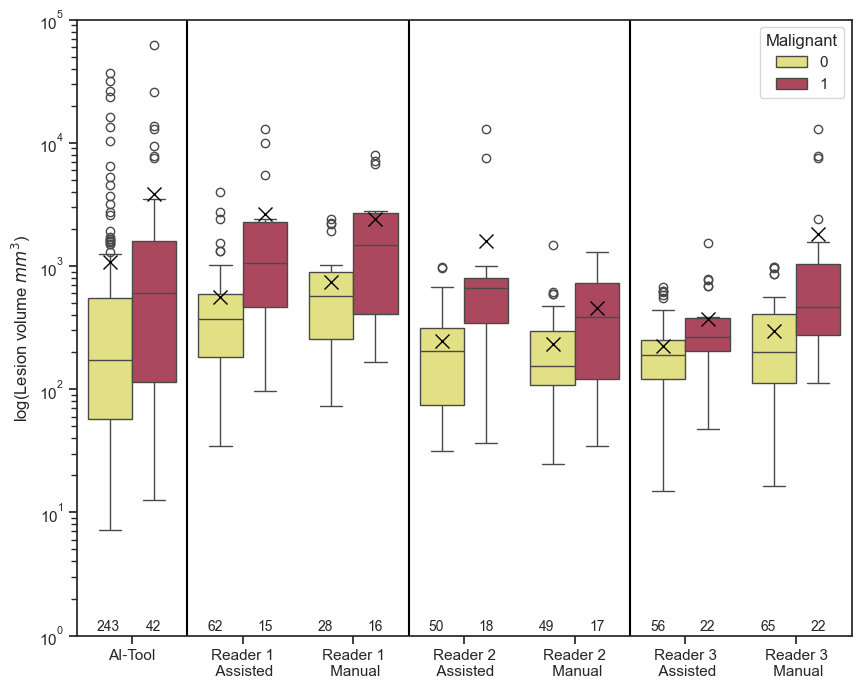

In [46]:
fig, (ax1) = plt.subplots(nrows=1,ncols=1,figsize=(10,8))


sns.boxplot(ax=ax1, x="Annotator", y="volume_mm3", whis=1.5,showmeans=True, hue='Malignant', palette=[benign_color,malignant_color],
                        meanprops={"marker":"x",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},  data=lesion_volumes)

ax1.set_yscale('log')
ax1.set_ylim([1,100000])
ax1.set_ylabel(r'log(Lesion volume $mm^3$)')
ax1.set_xlabel(r'')


#-------------------------------------------------
#Make a signficiance test for each the pairs:

#Kruskal Wallis for any number of distributions:
#AI-Tool:
ai_tool = lesion_volumes.loc[(lesion_volumes['annotation_type'] == 'AI-Tool')]
ai_tool_0 = lesion_volumes.loc[(lesion_volumes['annotation_type'] == 'AI-Tool') & (lesion_volumes['Malignant'] == 0)]
ai_tool_1 = lesion_volumes.loc[(lesion_volumes['annotation_type'] == 'AI-Tool') & (lesion_volumes['Malignant'] == 1)]
print(pg.pairwise_tests(data=ai_tool,dv='volume_mm3',alpha=0.05,parametric=False,between='Malignant',padjust='bonf',effsize='cohen',alternative='two-sided'))
print('ai_tool: ',scipy.stats.kruskal(ai_tool_0['volume_mm3'],ai_tool_1['volume_mm3'],nan_policy='propagate', axis=0, keepdims=False))
print('\n')
#Reader 1 Assisted:
Reader1_assisted = lesion_volumes.loc[(lesion_volumes['reader'] == 'rad1') & (lesion_volumes['annotation_type'] == 'Assisted')]
Reader1_assisted_0 = lesion_volumes.loc[(lesion_volumes['reader'] == 'rad1') & (lesion_volumes['annotation_type'] == 'Assisted') & (lesion_volumes['Malignant'] == 0)]
Reader1_assisted_1 = lesion_volumes.loc[(lesion_volumes['reader'] == 'rad1') & (lesion_volumes['annotation_type'] == 'Assisted') & (lesion_volumes['Malignant'] == 1)]
print(pg.pairwise_tests(data=Reader1_assisted,dv='volume_mm3',alpha=0.05,parametric=False,between='Malignant',padjust='bonf',effsize='cohen',alternative='two-sided'))
print('Reader 1 Assisted: ',scipy.stats.kruskal(Reader1_assisted_0['volume_mm3'],Reader1_assisted_1['volume_mm3'],nan_policy='propagate', axis=0, keepdims=False))

#Reader 1 Manual:
Reader1_manual = lesion_volumes.loc[(lesion_volumes['reader'] == 'rad1') & (lesion_volumes['annotation_type'] == 'Manual')]
Reader1_manual_0 = lesion_volumes.loc[(lesion_volumes['reader'] == 'rad1') & (lesion_volumes['annotation_type'] == 'Manual') & (lesion_volumes['Malignant'] == 0)]
Reader1_manual_1 = lesion_volumes.loc[(lesion_volumes['reader'] == 'rad1') & (lesion_volumes['annotation_type'] == 'Manual') & (lesion_volumes['Malignant'] == 1)]
print(pg.pairwise_tests(data=Reader1_manual,dv='volume_mm3',alpha=0.05,parametric=False,between='Malignant',padjust='bonf',effsize='cohen',alternative='two-sided'))
print('Reader 1 Manual: ',scipy.stats.kruskal(Reader1_manual_0['volume_mm3'],Reader1_manual_1['volume_mm3'],nan_policy='propagate', axis=0, keepdims=False))
print('\n')
#Reader 2 Assisted:
Reader2_assisted = lesion_volumes.loc[(lesion_volumes['reader'] == 'rad2') & (lesion_volumes['annotation_type'] == 'Assisted')]
Reader2_assisted_0 = lesion_volumes.loc[(lesion_volumes['reader'] == 'rad2') & (lesion_volumes['annotation_type'] == 'Assisted') & (lesion_volumes['Malignant'] == 0)]
Reader2_assisted_1 = lesion_volumes.loc[(lesion_volumes['reader'] == 'rad2') & (lesion_volumes['annotation_type'] == 'Assisted') & (lesion_volumes['Malignant'] == 1)]
print(pg.pairwise_tests(data=Reader1_assisted,dv='volume_mm3',alpha=0.05,parametric=False,between='Malignant',padjust='bonf',effsize='cohen',alternative='two-sided'))
print('Reader 2 Assisted: ',scipy.stats.kruskal(Reader2_assisted_0['volume_mm3'],Reader2_assisted_1['volume_mm3'],nan_policy='propagate', axis=0, keepdims=False))

#Reader 2 Manual:
Reader2_manual = lesion_volumes.loc[(lesion_volumes['reader'] == 'rad2') & (lesion_volumes['annotation_type'] == 'Manual')]
Reader2_manual_0 = lesion_volumes.loc[(lesion_volumes['reader'] == 'rad2') & (lesion_volumes['annotation_type'] == 'Manual') & (lesion_volumes['Malignant'] == 0)]
Reader2_manual_1 = lesion_volumes.loc[(lesion_volumes['reader'] == 'rad2') & (lesion_volumes['annotation_type'] == 'Manual') & (lesion_volumes['Malignant'] == 1)]
print(pg.pairwise_tests(data=Reader2_manual,dv='volume_mm3',alpha=0.05,parametric=False,between='Malignant',padjust='bonf',effsize='cohen',alternative='two-sided'))
print('Reader 2 Manual: ',scipy.stats.kruskal(Reader2_manual_0['volume_mm3'],Reader2_manual_1['volume_mm3'],nan_policy='propagate', axis=0, keepdims=False))

print('\n')
#Reader 3 Assisted:
Reader3_assisted = lesion_volumes.loc[(lesion_volumes['reader'] == 'rad3') & (lesion_volumes['annotation_type'] == 'Assisted')]
Reader3_assisted_0 = lesion_volumes.loc[(lesion_volumes['reader'] == 'rad3') & (lesion_volumes['annotation_type'] == 'Assisted') & (lesion_volumes['Malignant'] == 0)]
Reader3_assisted_1 = lesion_volumes.loc[(lesion_volumes['reader'] == 'rad3') & (lesion_volumes['annotation_type'] == 'Assisted') & (lesion_volumes['Malignant'] == 1)]
print(pg.pairwise_tests(data=Reader3_assisted,dv='volume_mm3',alpha=0.05,parametric=False,between='Malignant',padjust='bonf',effsize='cohen',alternative='two-sided'))
print('Reader 3 Assisted: ',scipy.stats.kruskal(Reader3_assisted_0['volume_mm3'],Reader3_assisted_1['volume_mm3'],nan_policy='propagate', axis=0, keepdims=False))

#Reader 3 Manual:
Reader3_manual = lesion_volumes.loc[(lesion_volumes['reader'] == 'rad3') & (lesion_volumes['annotation_type'] == 'Manual')]
Reader3_manual_0 = lesion_volumes.loc[(lesion_volumes['reader'] == 'rad3') & (lesion_volumes['annotation_type'] == 'Manual') & (lesion_volumes['Malignant'] == 0)]
Reader3_manual_1 = lesion_volumes.loc[(lesion_volumes['reader'] == 'rad3') & (lesion_volumes['annotation_type'] == 'Manual') & (lesion_volumes['Malignant'] == 1)]
print(pg.pairwise_tests(data=Reader3_manual,dv='volume_mm3',alpha=0.05,parametric=False,between='Malignant',padjust='bonf',effsize='cohen',alternative='two-sided'))
print('Reader 3 Manual: ',scipy.stats.kruskal(Reader3_manual_0['volume_mm3'],Reader3_manual_1['volume_mm3'],nan_policy='propagate', axis=0, keepdims=False))


plt.text(x = -0.32, y = 1.1, s = f"{ai_tool_0.shape[0]}", size = 10)
plt.text(x = -0.32+0.45, y = 1.1, s = f"{ai_tool_1.shape[0]}", size = 10)

plt.text(x = -0.32+1, y = 1.1, s = f"{Reader1_assisted_0.shape[0]}", size = 10)
plt.text(x = -0.32+1+0.45, y = 1.1, s = f"{Reader1_assisted_1.shape[0]}", size = 10)
plt.text(x = -0.32+2, y = 1.1, s = f"{Reader1_manual_0.shape[0]}", size = 10)
plt.text(x = -0.32+2+0.45, y = 1.1, s = f"{Reader1_manual_1.shape[0]}", size = 10)

plt.text(x = -0.32+3, y = 1.1, s = f"{Reader2_assisted_0.shape[0]}", size = 10)
plt.text(x = -0.32+3+0.45, y = 1.1, s = f"{Reader2_assisted_1.shape[0]}", size = 10)
plt.text(x = -0.32+4, y = 1.1, s = f"{Reader2_manual_0.shape[0]}", size = 10)
plt.text(x = -0.32+4+0.45, y = 1.1, s = f"{Reader2_manual_1.shape[0]}", size = 10)

plt.text(x = -0.32+5, y = 1.1, s = f"{Reader3_assisted_0.shape[0]}", size = 10)
plt.text(x = -0.32+5+0.45, y = 1.1, s = f"{Reader3_assisted_1.shape[0]}", size = 10)
plt.text(x = -0.32+6, y = 1.1, s = f"{Reader3_manual_0.shape[0]}", size = 10)
plt.text(x = -0.32+6+0.45, y = 1.1, s = f"{Reader3_manual_1.shape[0]}", size = 10)


ax1.axvline(x=0.5, color='black')
ax1.axvline(x=2.5, color='black')
ax1.axvline(x=4.5, color='black')

ax1.set_xticklabels(['AI-Tool','Reader 1\n Assisted','Reader 1\n Manual',
                    'Reader 2\n Assisted','Reader 2\n Manual',
                    'Reader 3\n Assisted','Reader 3\n Manual'])

path = 'figures_volume_calculation/lesion_volume_Gleason_ass_man.svg'
plt.savefig(path, format='svg',bbox_inches='tight')


In [47]:
lesion_volumes

,volume_mm3,n_pixels,site,reader,annotation_type,PI-QUAL,PI-RADS,Annotator,Gleason,ISUP_Grade_Group,Malignant
bell-0001_t2w_les-0--p-5--g-0_pcai100_auto.nii.gz,26022.581459,52515,bell,pcai100,AI-Tool,3,5,AI-Tool,6,3,1
bell-0001_t2w_les-0--p-5--g-0_rad1_ass.nii.gz,1546.043114,3120,bell,rad1,Assisted,3,5,rad1_Assisted,6,3,1
bell-0001_t2w_les-0--p-5--g-0_rad1_rad.nii.gz,1709.566905,3450,bell,rad1,Manual,3,5,rad1_Manual,6,3,1
bell-0001_t2w_les-0--p-5--g-0_rad2_ass.nii.gz,715.540467,1444,bell,rad2,Assisted,3,5,rad2_Assisted,6,3,1
bell-0001_t2w_les-0--p-5--g-0_rad2_rad.nii.gz,724.955473,1463,bell,rad2,Manual,3,5,rad2_Manual,6,3,1
bell-0001_t2w_les-1--p-5--g-0_pcai100_auto.nii.gz,410.791584,829,bell,pcai100,AI-Tool,3,5,AI-Tool,0,1,0
bell-0001_t2w_les-1--p-5--g-0_rad2_rad.nii.gz,127.350346,257,bell,rad2,Manual,3,5,rad2_Manual,3,1,0
bell-0010_t2w_les-0--p-4--g-0_rad1_ass.nii.gz,145.019529,288,bell,rad1,Assisted,3,4,rad1_Assisted,2,1,0
bell-0010_t2w_les-0--p-4--g-0_rad1_rad.nii.gz,92.651366,184,bell,rad1,Manual,3,4,rad1_Manual,2,1,0
bell-0010_t2w_les-0--p-4--g-0_rad2_rad.nii.gz,26.687622,53,bell,rad2,Manual,3,4,rad2_Manual,2,1,0
